### Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time
* Scheduled project review date/time: 9/07/2020 - 2:00pm
* Instructor name: James Irving
* Blog post URL:


<img src="fb_logo_rect.jpg">

## Introduction

In this notebook, we will be examining data from house sales in King County, Washington in order to determine what a potential seller may be able to do in order to increase the final sale price of their home.  While there are many factors at play when it comes to home value, we will attempt to figure out key features that drive sale price using data scrubbing and linear regression models.  

In this notebook, we will answer several questions:
  - Is the dataset affected by the presence of outliers?
  - Are there issues of data being encoded as the wrong type?
  - Will our initial model be affected by multicolinearity? 
  - Most importantly, what features drive the overall sale price of a house in King County?

### Note About Certain Sections

In this notebook, there are a few instances of entire sections of code that's commented out.  During this process, I've tried many different methods for each step with varied levels of success.  At this time, I did not want to remove code that could prove useful down the line.

### Importing Packages

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

# for making a fun matrix
import missingno as ms

#for feature engineering
from sklearn.preprocessing import StandardScaler

# for modeling
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# for feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Functions

In [2]:
def df_info(df):
    '''gets shape, describe and info for datasets'''
    return df.shape, df.describe(), df.info()

def scatter_plot_exploration(col):
    ''' Creates a scatter plot, typically to be iterated over a column'''
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = df[col], y = df['price'])
    ax.set_title('{} vs. Price'.format(col), fontsize = 20)
    ax.set_xlabel('{}'.format(col), fontsize = 16)
    ax.set_ylabel('Sale Price', fontsize = 16);

def plot_col(df, col, target = 'price'):
    ''' Creates a jointplot, typically to be iterated over a column'''
    g = sns.jointplot(data = df, x = col, y = target, kind = 'reg')
    plt.suptitle(f"{col} vs. {target}");
    return g

def outliers_range_iqr(df, column, distance = 1.5):
    ''' Finds the iqr range of a column'''
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    lower_threshold = df[column].quantile(0.25) - (iqr * distance)
    upper_threshold = df[column].quantile(0.75) + (iqr * distance)
    return lower_threshold, upper_threshold

def find_outliers_iqr(df, column):
    ''' Identifiest the outliers in a column'''
    lower_threshold, upper_threshold = outliers_range_iqr(df, column)
    outliers = []
    for i in df[column]:
        if i > upper_threshold:
            outliers.append(i)
        elif i < lower_threshold:
            outliers.append(i)
        else: 
            pass
    return outliers

def remove_outliers_iqr(df, column):
    ''' Removes the outliers in a column'''
    outliers = find_outliers_iqr(df, column)
    outliers = pd.Series(outliers)
    df_new = df[~df[column].isin(outliers)]
    return df_new
    
def normalize(feature):
    ''' Normalizes a feature'''
    return (feature - feature.mean()) / feature.std()

def heatmap(df):
    ''' displays a heatmap of an entire dataframe'''
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (16,12))
    sns.set(style = 'white')
    sns.heatmap(corr, mask = mask, cmap="Blues", annot = True);
    
def diagnostic_plots (df, column):
    ''' Creates figures to help figure out normality for a column'''
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    df[column].hist(bins = 30)
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist = 'norm', plot = plt)
    plt.title('{}'.format(column))
    plt.show()
    
def scatter_box_plots (df, column):
    ''' Displays scatter and box plot, mainly for checking for outliers'''
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.regplot(data = df, x = column, y = 'price', fit_reg = True)
    plt.title('{}'.format(column))
    plt.subplot(1,2,2)
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

def correlation(df, threshold):
    ''' Checks for correlated features'''
    col_corr = set() # set of corellated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr
    
def coefficient_barplot(df, x, y):
    ''' Creates a barplot for a particular coefficient'''
    ax = plt.figure(figsize = (14,6))
    ax = sns.barplot(data = df, x = x, y = y)
    ax.set_title('Coefficient by {}'.format(x), fontsize = 20)
    ax.set_xlabel('{}'.format(x), fontsize = 16)
    ax.set_ylabel('{}'.format(y), fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45);

## Obtain


### Import Data

In [3]:
# Loading and previewing the dataset

df = pd.read_csv('kc_house_data.csv')
pd.set_option('display.max_columns', 0)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # not sure this is working
df.head()

id        date      price  ...     long  sqft_living15  sqft_lot15
0  7129300520  10/13/2014 221900.000  ... -122.257           1340        5650
1  6414100192   12/9/2014 538000.000  ... -122.319           1690        7639
2  5631500400   2/25/2015 180000.000  ... -122.233           2720        8062
3  2487200875   12/9/2014 604000.000  ... -122.393           1360        5000
4  1954400510   2/18/2015 510000.000  ... -122.045           1800        7503

[5 rows x 21 columns]

In [4]:
# Created for plots 

plotting_df = df.copy()

## Scrub

##### Column Descriptions
>Below are the column descriptions that were given along with the dataset.  

- id - A notation for a house
- date - Date house was sold
- price - Price is prediction target
- bedrooms Number of Bedrooms/House
- bathrooms - Number of bathrooms/bedrooms
- sqft_living - Square footage of the home
- sqft_lot - Square footage of the lot
- floors - Total floors (levels) in house
- waterfront - House which has a view to a waterfront
- view - Has been viewed
- condition - How good the condition is ( Overall )
- grade - Overall grade given to the housing unit, based on King County grading system
- sqft_above - square footage of house apart from basement
- sqft_basement - square footage of the basement
- yr_built - Built Year
- yr_renovated - Year when house was renovated
- zipcode - Zipcode
- lat - Latitude coordinate
- long - Longitude coordinate
- sqft_living15 - Living room area in 2015 (implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15 - Lot size area in 2015 (implies-- some renovations)

In [5]:
df.head()

id        date      price  ...     long  sqft_living15  sqft_lot15
0  7129300520  10/13/2014 221900.000  ... -122.257           1340        5650
1  6414100192   12/9/2014 538000.000  ... -122.319           1690        7639
2  5631500400   2/25/2015 180000.000  ... -122.233           2720        8062
3  2487200875   12/9/2014 604000.000  ... -122.393           1360        5000
4  1954400510   2/18/2015 510000.000  ... -122.045           1800        7503

[5 rows x 21 columns]

In [6]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

((21597, 21),
                   id       price  bedrooms  ...      long  sqft_living15  sqft_lot15
 count      21597.000   21597.000 21597.000  ... 21597.000      21597.000   21597.000
 mean  4580474287.771  540296.574     3.373  ...  -122.214       1986.620   12758.284
 std   2876735715.748  367368.140     0.926  ...     0.141        685.230   27274.442
 min      1000102.000   78000.000     1.000  ...  -122.519        399.000     651.000
 25%   2123049175.000  322000.000     3.000  ...  -122.328       1490.000    5100.000
 50%   3904930410.000  450000.000     3.000  ...  -122.231       1840.000    7620.000
 75%   7308900490.000  645000.000     4.000  ...  -122.125       2360.000   10083.000
 max   9900000190.000 7700000.000    33.000  ...  -121.315       6210.000  871200.000
 
 [8 rows x 19 columns],
 None)

>Seems to be some weirdness in here with the datatypes.  We can explore this further later on.  For now, we can drop the id column as it's just meant to be an identifier. 

In [7]:
# Dropping the id column 

df.drop(['id'], axis = 1, inplace = True)

### Dealing with sqft_basement column

In [8]:
# Checking the value counts of sqft_basement.

df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
207.0         1
2500.0        1
666.0         1
374.0         1
295.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [9]:
# Replacing the ? with nan's and changing the dtype from string to float. 

df['sqft_basement'].replace('?', np.nan, inplace = True) 
df['sqft_basement'] = df['sqft_basement'].astype('float') 

### Dealing with the Date & Year Columns

#### Date Column to Datetime

In [10]:
df['date'] = pd.to_datetime(df['date']) # convert date column from string to datetime
df['sales_year'] = df['date'].dt.year
df['sales_month'] = df['date'].dt.month # create a column show month of sale
df['sales_day'] = df['date'].dt.dayofweek # create a column to show day of sale


In [11]:
df.drop(['date'], axis = 1, inplace = True) # dropping date column


In [12]:
 # checking to see how the values relate to the days.  According to docstring - 0 = Monday, 1 = Tuesday, etc.

df['sales_day'].unique()

array([0, 1, 2, 4, 3, 5, 6])

#### Year Column Transformation 


In [13]:
type(df['sales_year'][1])

numpy.int64

In [14]:
# Create a house age column 

df['house_age'] = df['sales_year'] - df['yr_built']

In [15]:
df.drop(['sales_year', 'yr_built'], axis = 1, inplace = True)
df.head()

price  bedrooms  bathrooms  ...  sales_month  sales_day  house_age
0 221900.000         3      1.000  ...           10          0         59
1 538000.000         3      2.250  ...           12          1         63
2 180000.000         2      1.000  ...            2          2         82
3 604000.000         4      3.000  ...           12          1         49
4 510000.000         3      2.000  ...            2          2         28

[5 rows x 21 columns]

In [16]:
# deal with null values in yr_renovated & change from float to int

df['yr_renovated'].mode() # mode = 0.0
df['yr_renovated'].fillna(0.0, axis = 0, inplace = True)
df['yr_renovated'] = df['yr_renovated'].astype('int') 
df.head()

price  bedrooms  bathrooms  ...  sales_month  sales_day  house_age
0 221900.000         3      1.000  ...           10          0         59
1 538000.000         3      2.250  ...           12          1         63
2 180000.000         2      1.000  ...            2          2         82
3 604000.000         4      3.000  ...           12          1         49
4 510000.000         3      2.000  ...            2          2         28

[5 rows x 21 columns]

In [17]:
df['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
        ...  
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

>Since there's so many 0 values in here, it would make sense to transform this column into a 'was_renovated' (1,0)

In [18]:
# Change the column to a boolean

for i in df['yr_renovated']:
    if i > 0:
        df['yr_renovated'].replace(i, 1, inplace = True)

# Change column name
df['was_renovated'] = df['yr_renovated']
df.drop(['yr_renovated'], axis = 1, inplace = True)

print(df['was_renovated'].value_counts())
df.head()

0    20853
1      744
Name: was_renovated, dtype: int64


price  bedrooms  bathrooms  ...  sales_day  house_age  was_renovated
0 221900.000         3      1.000  ...          0         59              0
1 538000.000         3      2.250  ...          1         63              1
2 180000.000         2      1.000  ...          2         82              0
3 604000.000         4      3.000  ...          1         49              0
4 510000.000         3      2.000  ...          2         28              0

[5 rows x 21 columns]

### Dealing with Remaining Null Values

In [19]:
# Let's preview the mildly edited dataframe again

df.head()

price  bedrooms  bathrooms  ...  sales_day  house_age  was_renovated
0 221900.000         3      1.000  ...          0         59              0
1 538000.000         3      2.250  ...          1         63              1
2 180000.000         2      1.000  ...          2         82              0
3 604000.000         4      3.000  ...          1         49              0
4 510000.000         3      2.000  ...          2         28              0

[5 rows x 21 columns]

In [20]:
print(df.shape)  # shape for reference
df.isna().sum()  # checking for null values

(21597, 21)


price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     454
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
sales_month         0
sales_day           0
house_age           0
was_renovated       0
dtype: int64

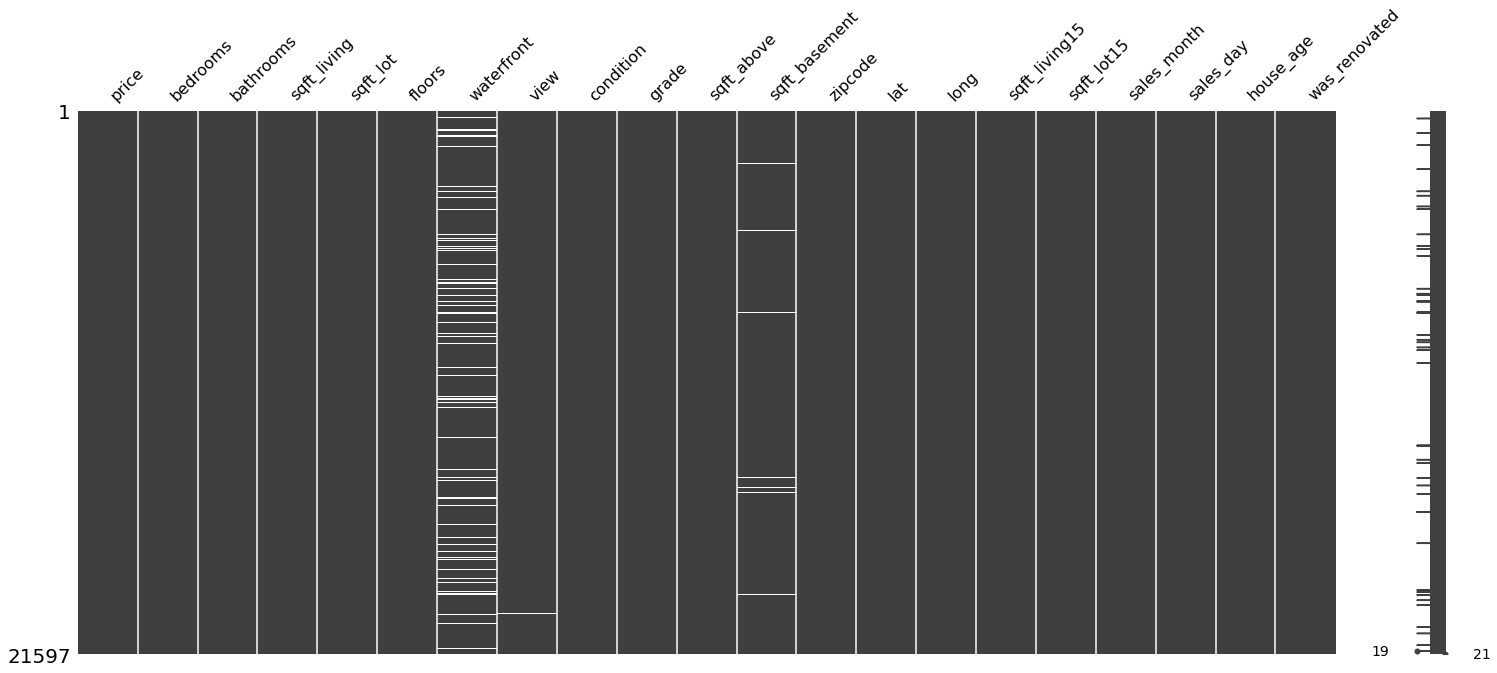

In [21]:
# Create a matrix to see the null values

ms.matrix(df);

In [22]:
# Replace nan's in watefront with the mode & change type to integer.
# for later: df['bedrooms'].mode()[0]

df['waterfront'].mode() # mode = 0.0
df['waterfront'].fillna(0.0, axis = 0, inplace = True)
df['waterfront'] = df['waterfront'].astype(int)

In [23]:
# Replace nan's in view with the mode & change type to integer.

df['view'].mode() # mode = 0.0
df['view'].fillna(0.0, axis = 0, inplace = True)
df['view'] = df['view'].astype(int)

In [24]:
# Replace nan's in sqft_basement.  Both median and mode are the same so for fun, let's do the median.

df['sqft_basement'].median()  # median = 0.0
df['sqft_basement'].fillna(0.0, axis = 0, inplace = True)

In [25]:
# Let's make sure the null values are all taken care of.

df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sales_month      0
sales_day        0
house_age        0
was_renovated    0
dtype: int64

## Explore

Now that we have at least a "clean" dataframe, let's see what additional scrubbing info we can pull out of it.  

### Exploratory Visualizations 

#### Scatter & Reg Plots

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


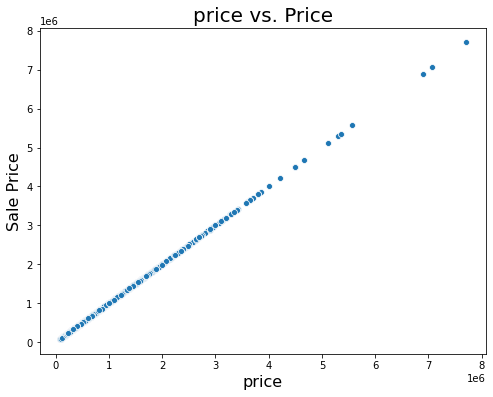

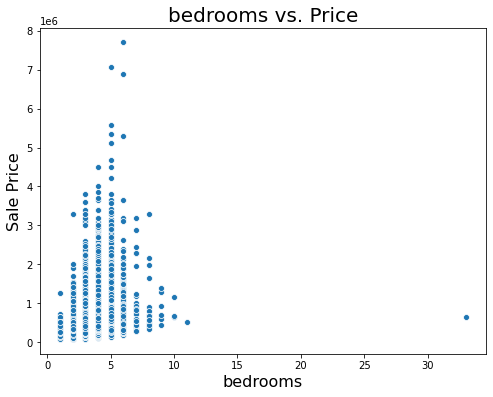

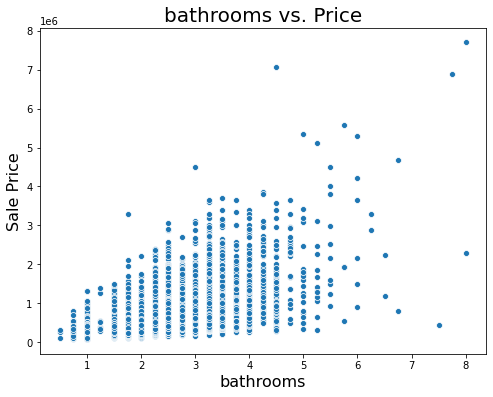

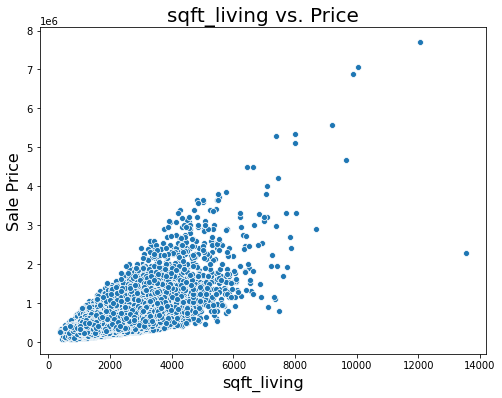

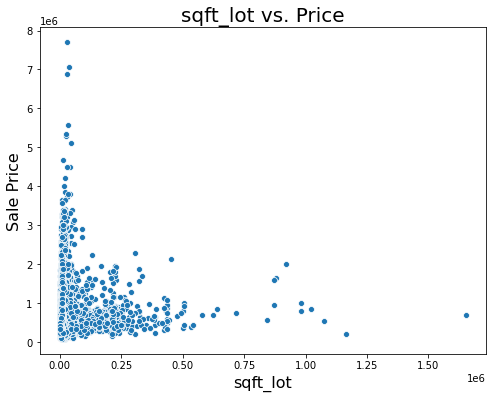

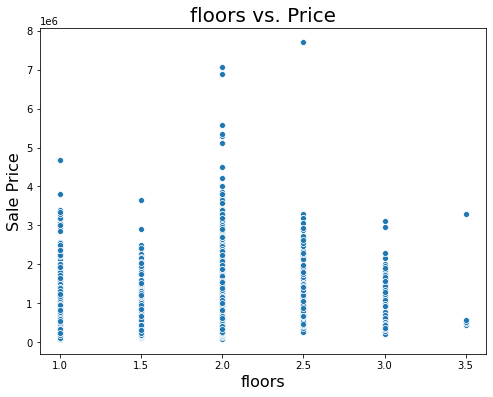

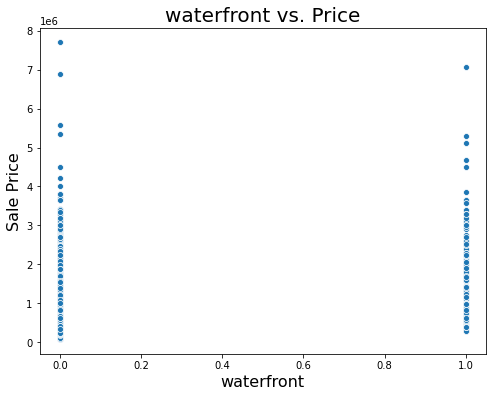

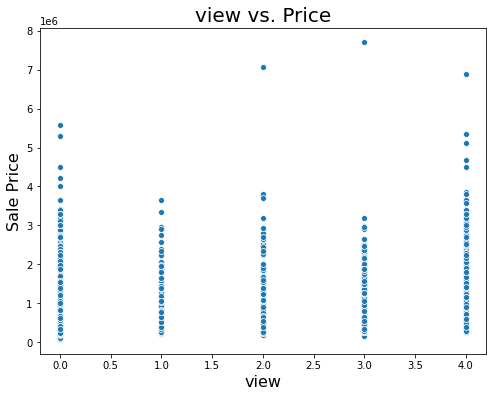

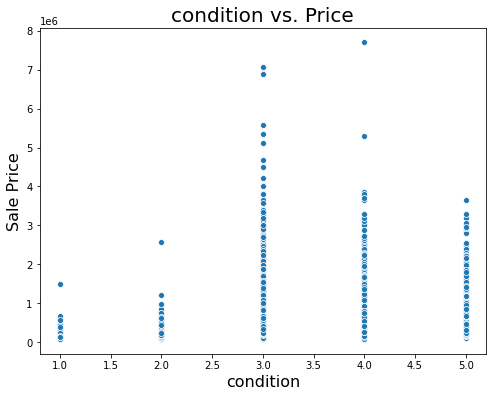

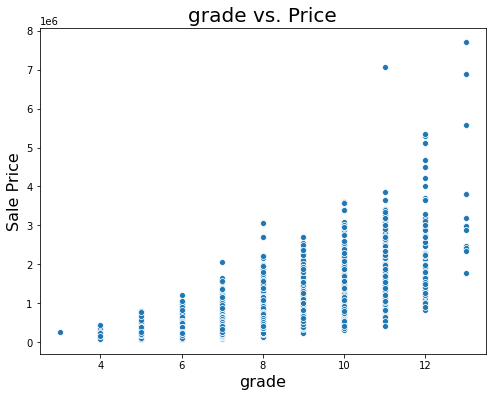

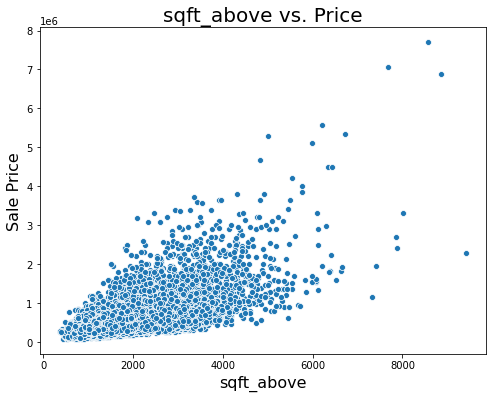

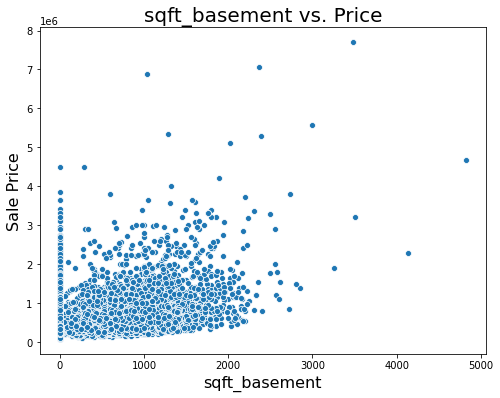

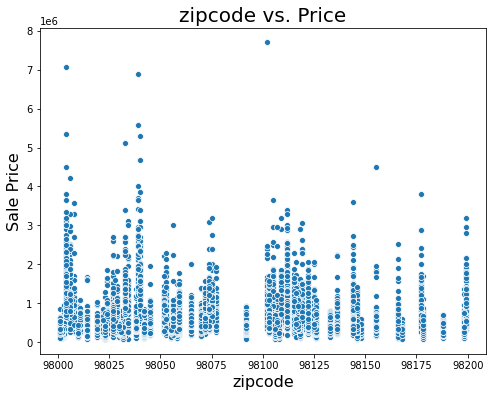

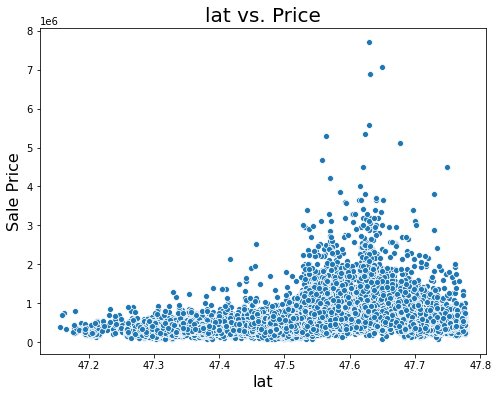

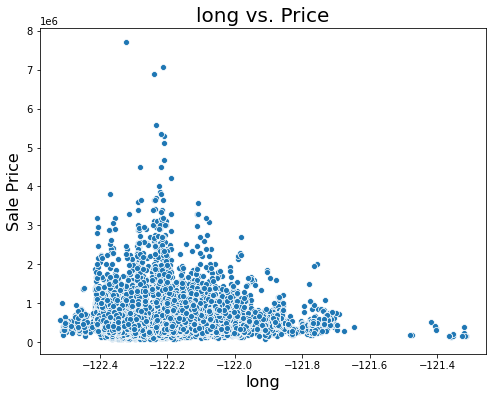

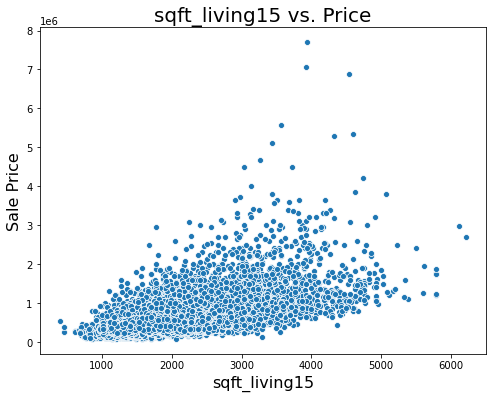

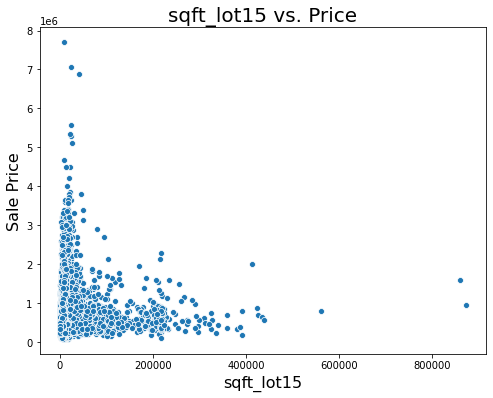

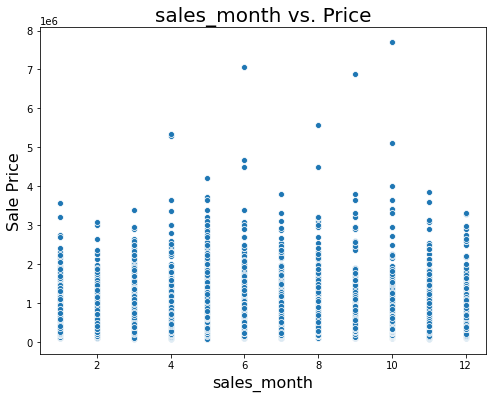

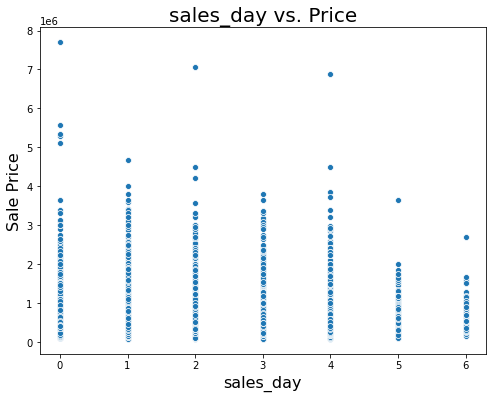

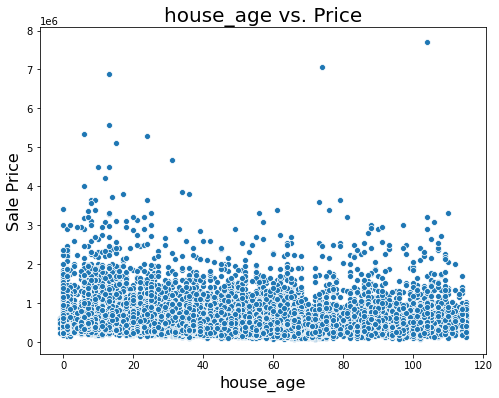

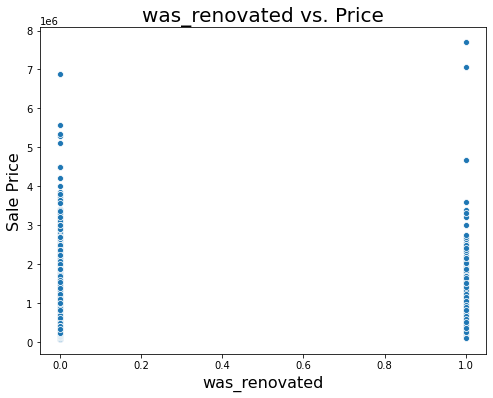

In [26]:
# Create scatter plots for the dataframe

for col in df.columns:
    scatter_plot_exploration(col)

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


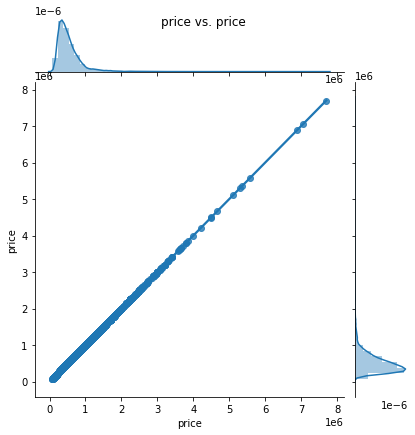

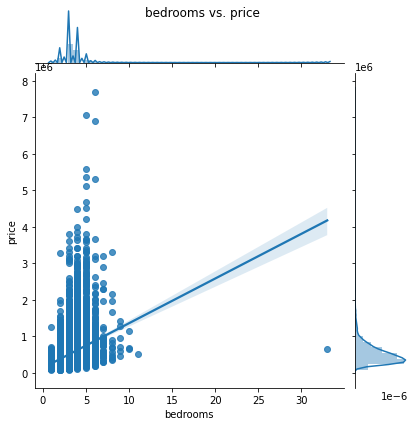

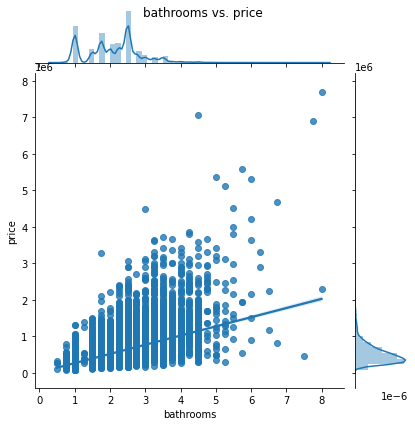

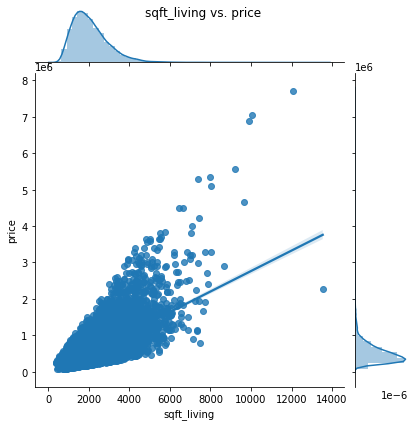

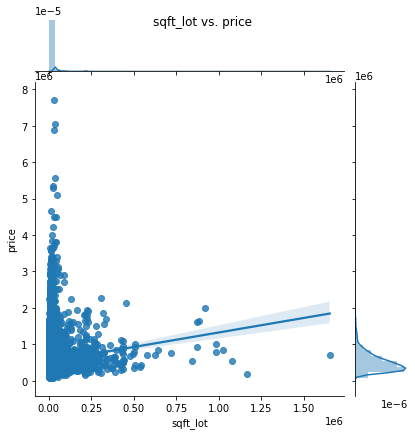

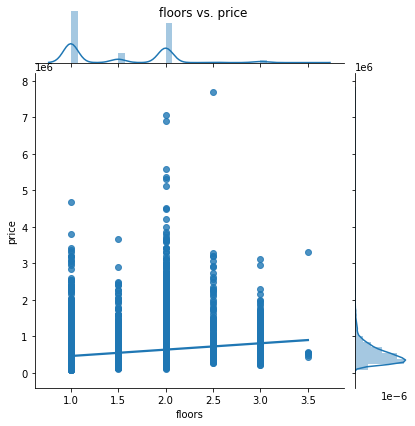

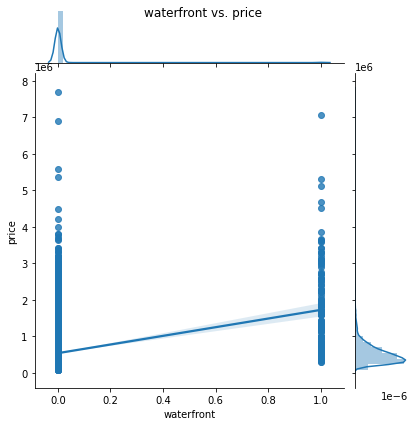

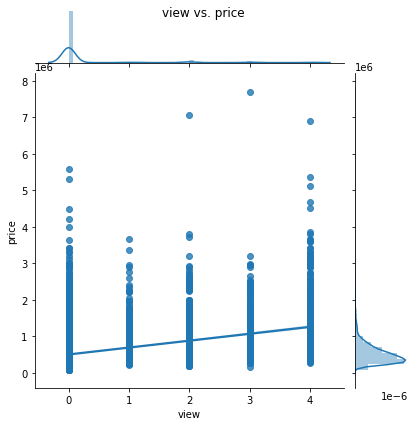

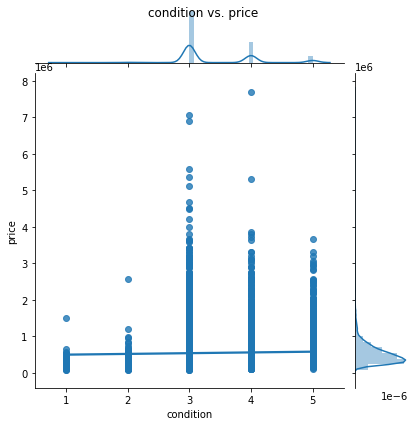

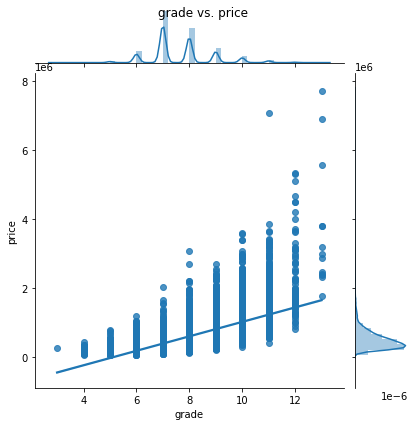

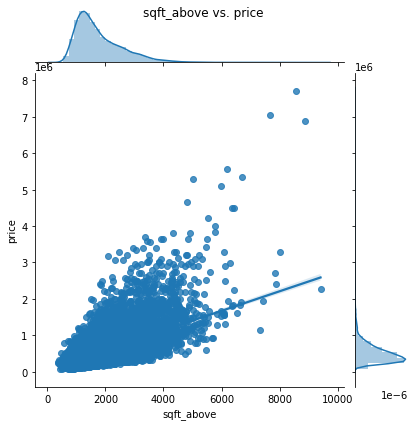

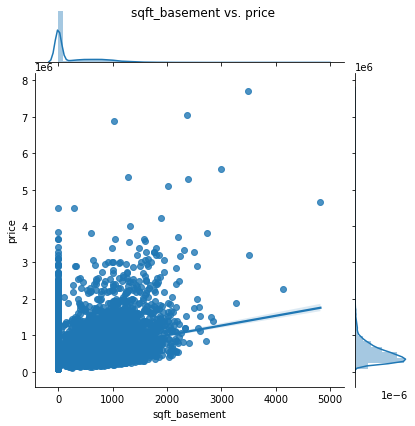

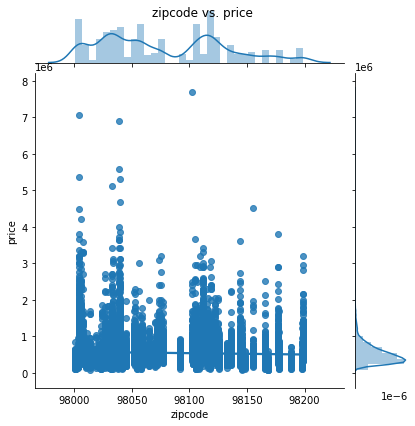

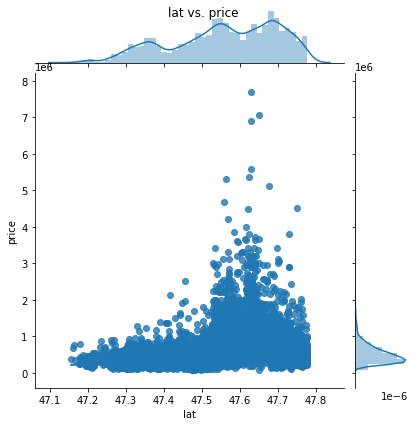

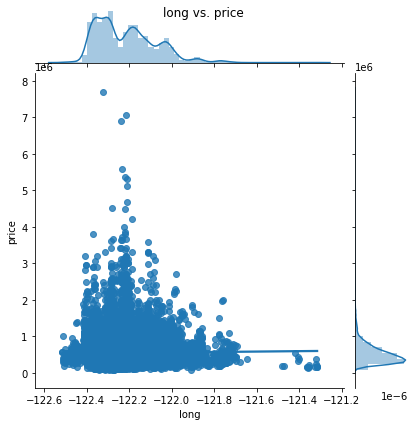

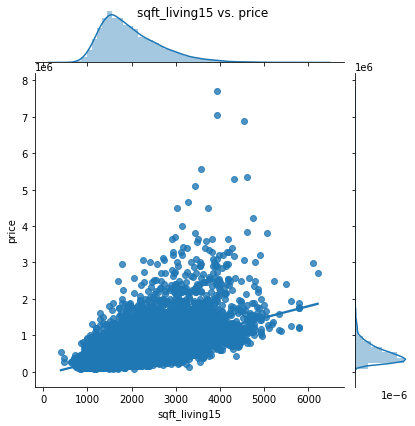

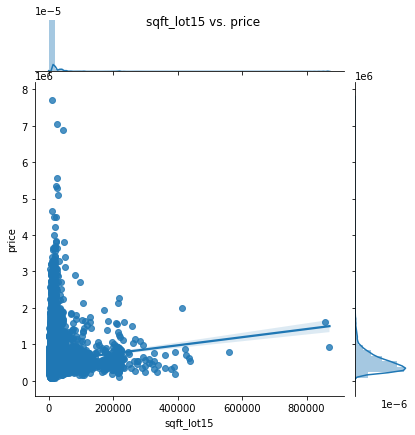

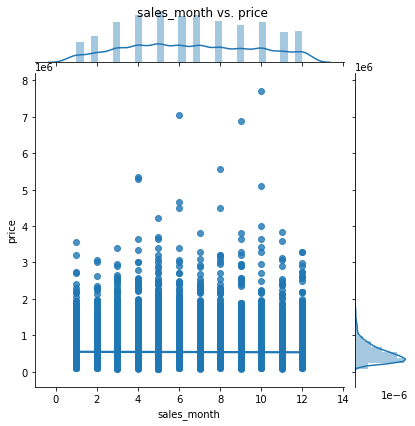

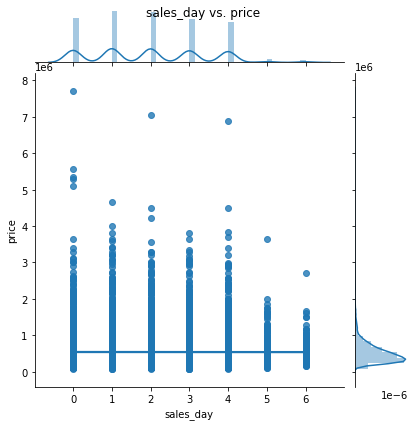

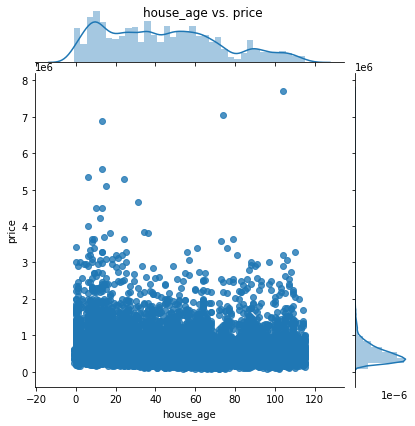

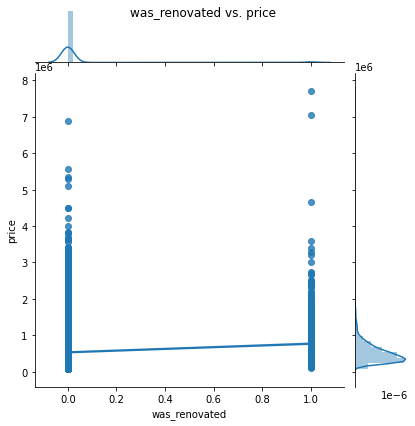

In [27]:
# Create regplots for the dataframe

for col in df.columns:
    plot_col(df, col)

### Initial Exploration

In [28]:
df.head()

price  bedrooms  bathrooms  ...  sales_day  house_age  was_renovated
0 221900.000         3      1.000  ...          0         59              0
1 538000.000         3      2.250  ...          1         63              1
2 180000.000         2      1.000  ...          2         82              0
3 604000.000         4      3.000  ...          1         49              0
4 510000.000         3      2.000  ...          2         28              0

[5 rows x 21 columns]

In [29]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  zipcode        21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
 15  sqft_living15  21597 non-null  int64  
 16  sqft_lot15     21597 non-null  int64  
 17  sales_month    21597 non-null  int64  
 18  sales_

((21597, 21),
             price  bedrooms  bathrooms  ...  sales_day  house_age  was_renovated
 count   21597.000 21597.000  21597.000  ...  21597.000  21597.000      21597.000
 mean   540296.574     3.373      2.116  ...      2.011     43.323          0.034
 std    367368.140     0.926      0.769  ...      1.461     29.377          0.182
 min     78000.000     1.000      0.500  ...      0.000     -1.000          0.000
 25%    322000.000     3.000      1.750  ...      1.000     18.000          0.000
 50%    450000.000     3.000      2.250  ...      2.000     40.000          0.000
 75%    645000.000     4.000      2.500  ...      3.000     63.000          0.000
 max   7700000.000    33.000      8.000  ...      6.000    115.000          1.000
 
 [8 rows x 21 columns],
 None)

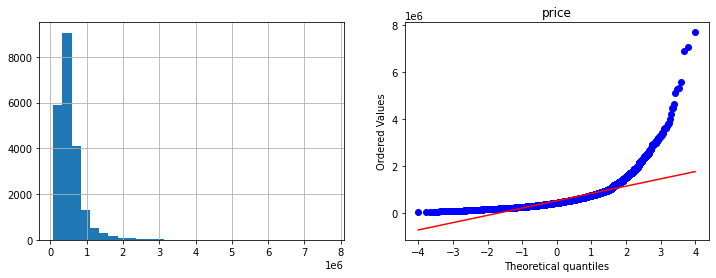

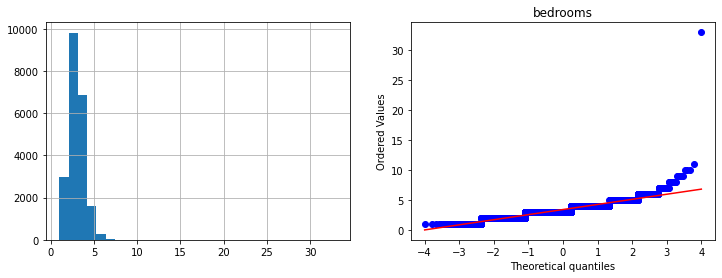

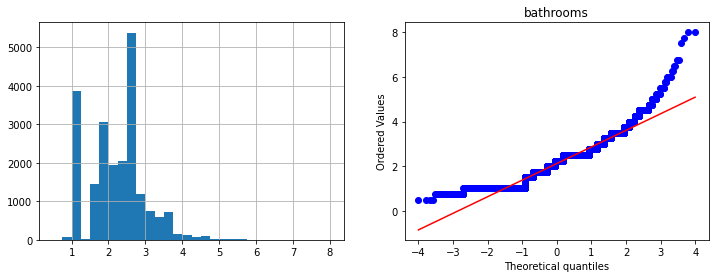

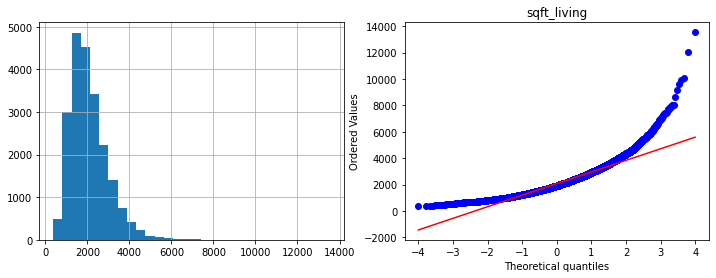

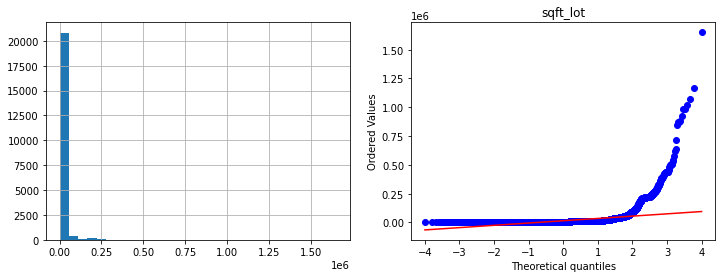

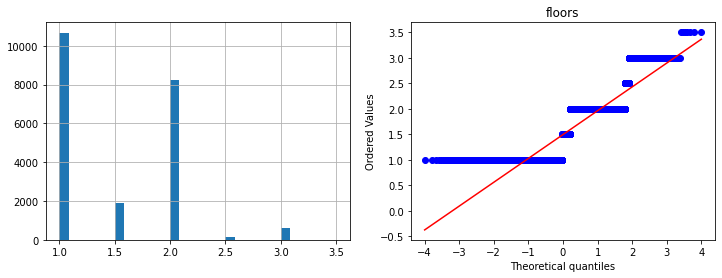

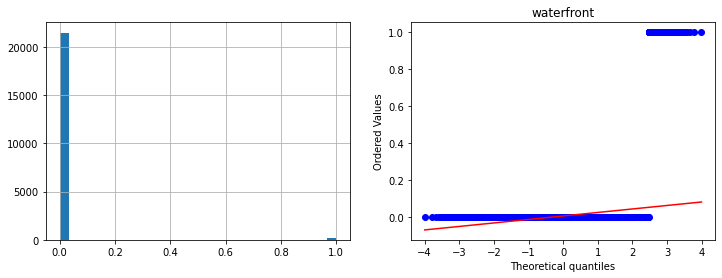

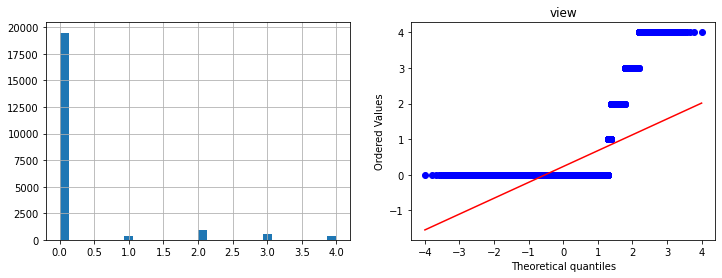

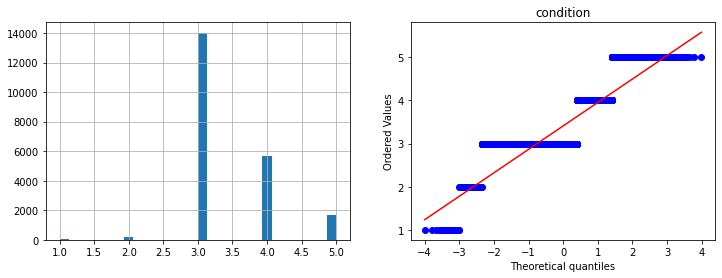

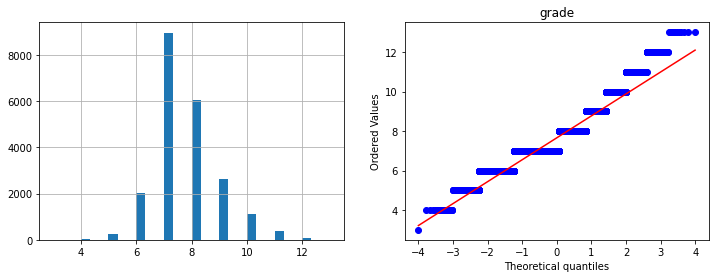

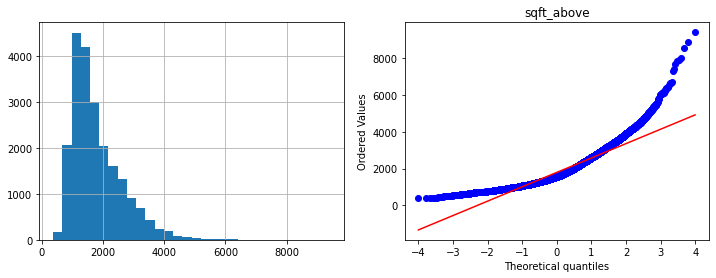

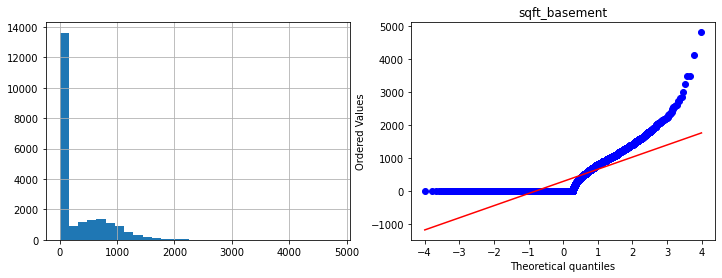

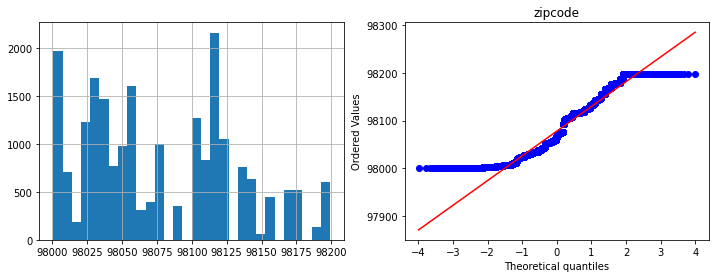

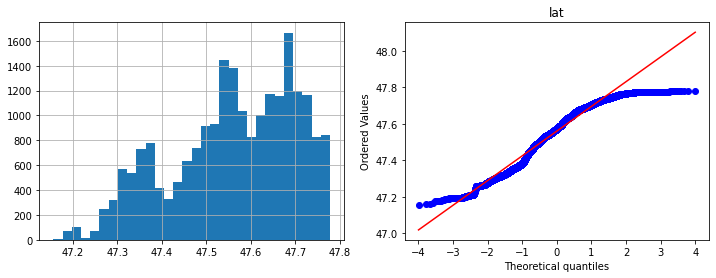

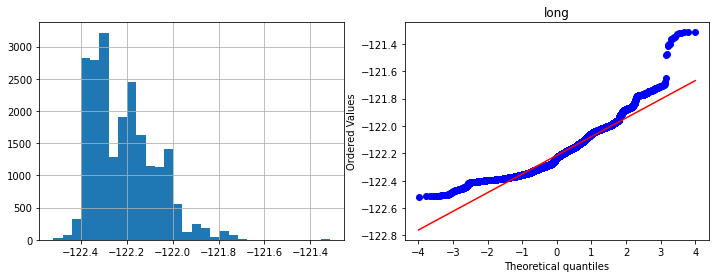

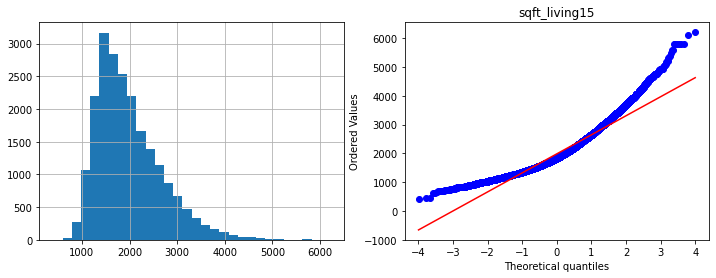

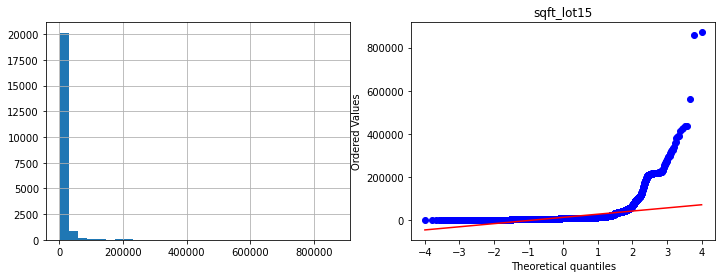

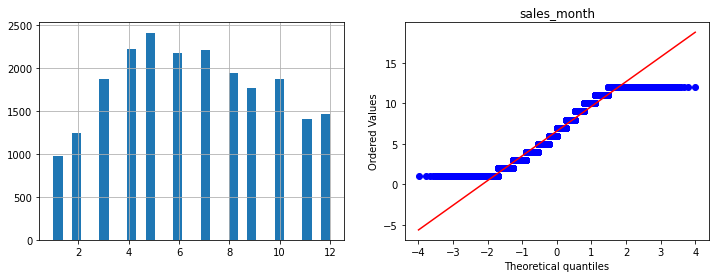

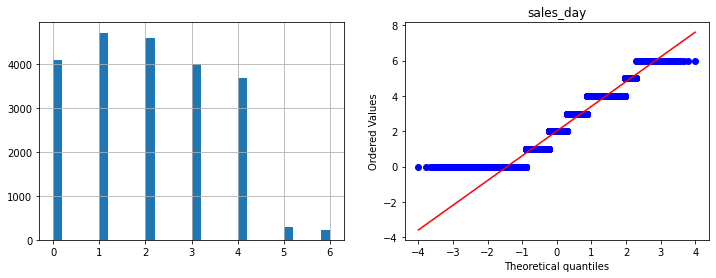

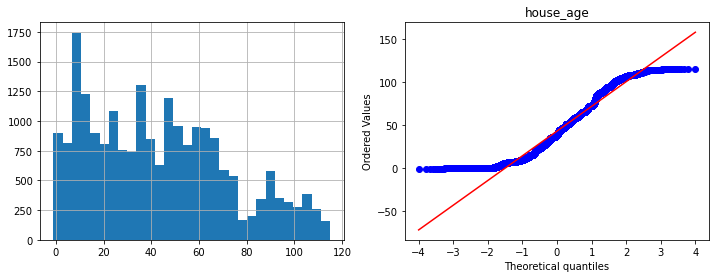

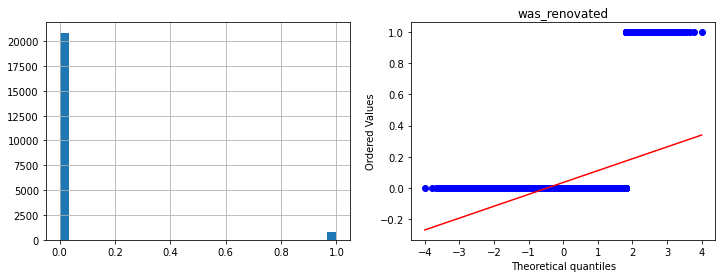

In [30]:
# Let's see what these columns look like 

for column in df.columns:
    diagnostic_plots(df, column)

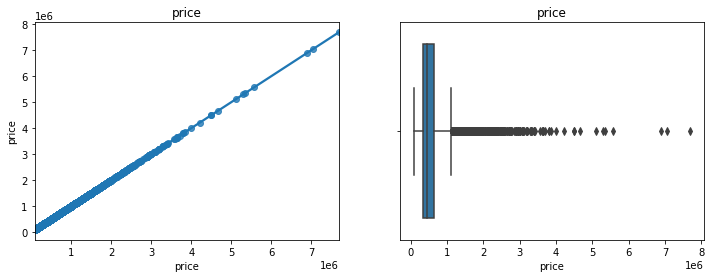

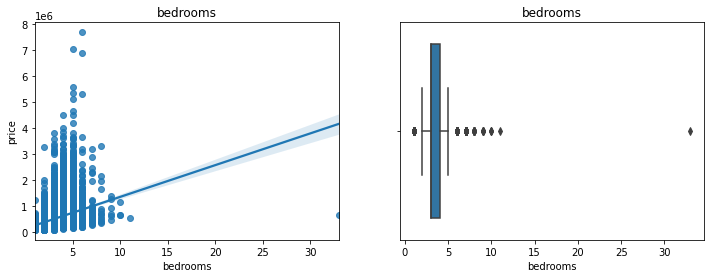

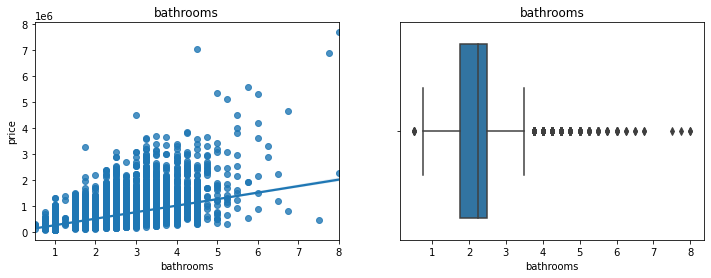

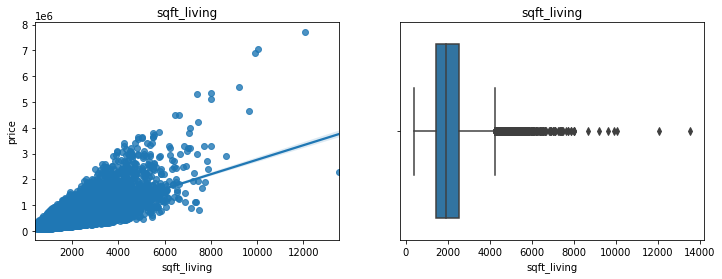

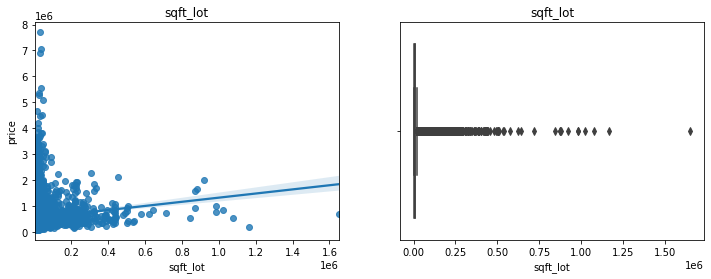

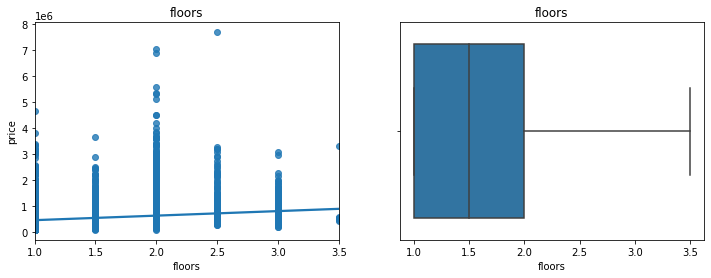

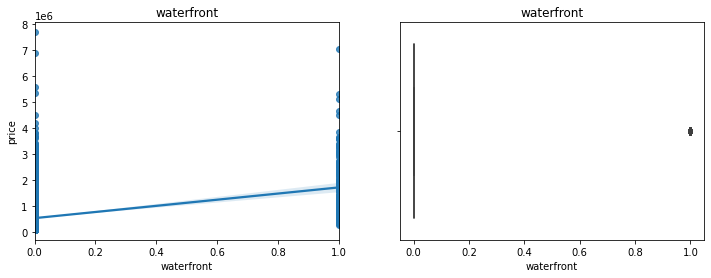

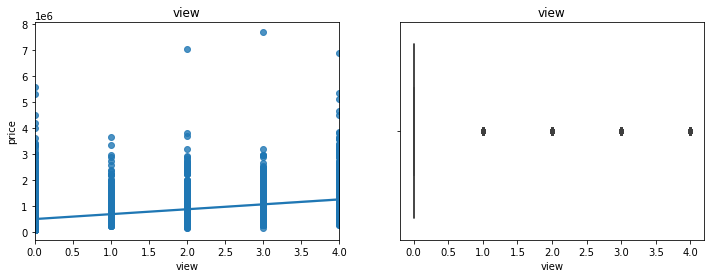

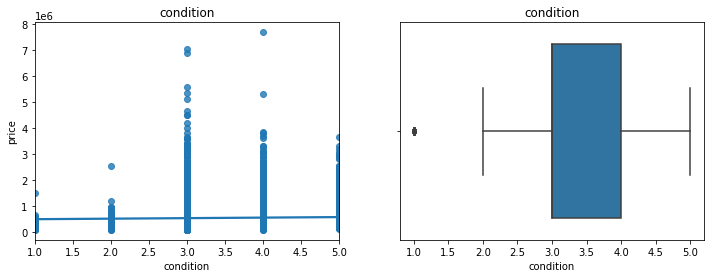

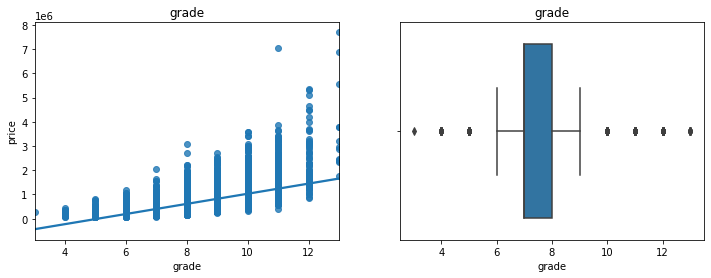

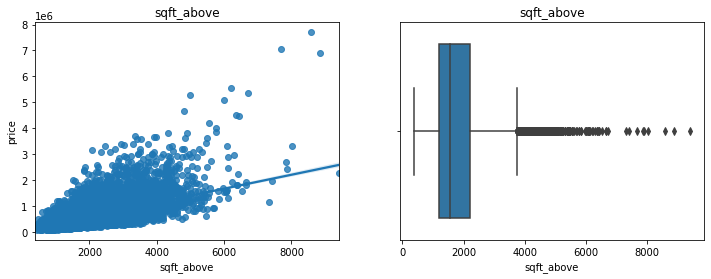

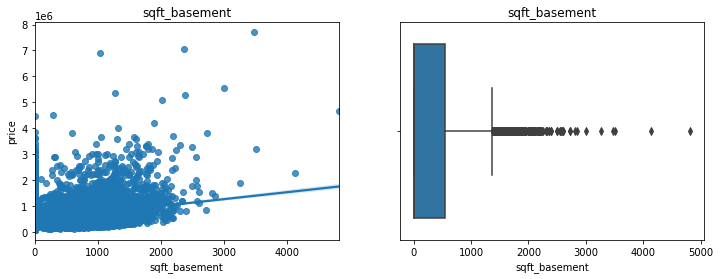

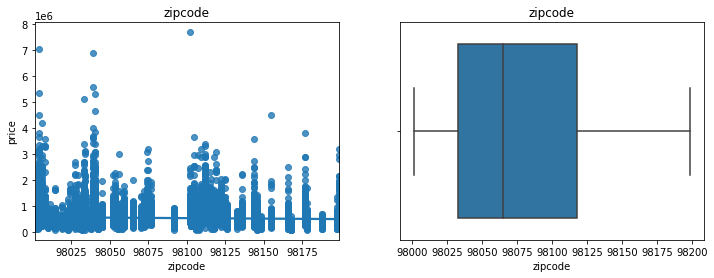

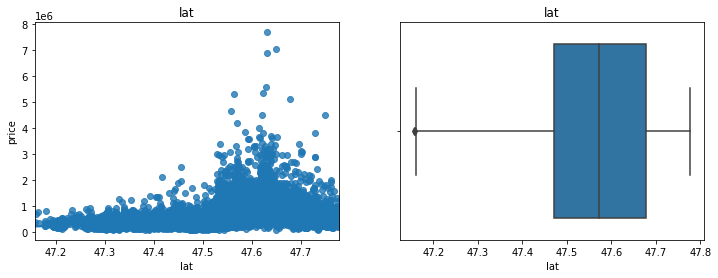

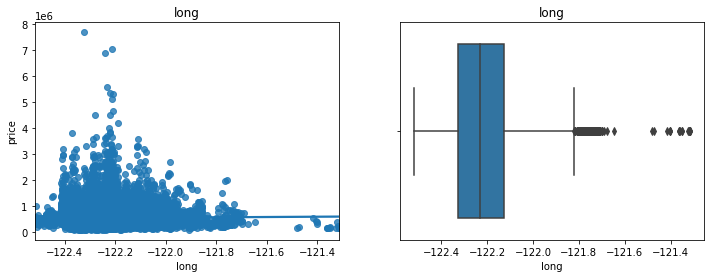

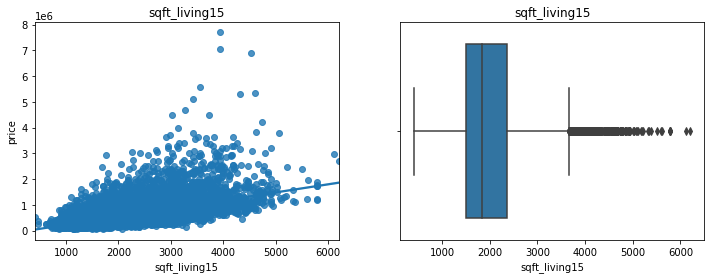

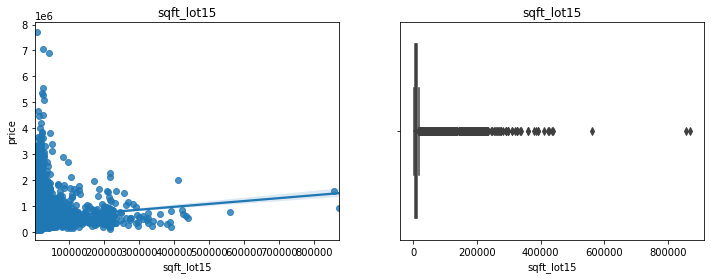

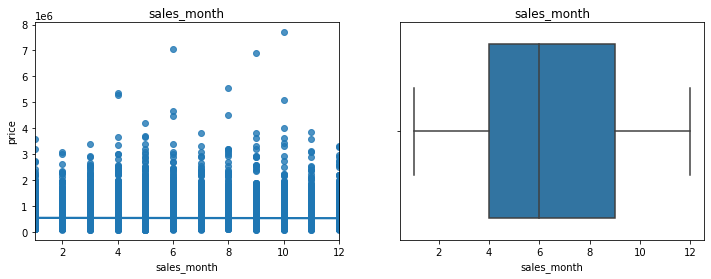

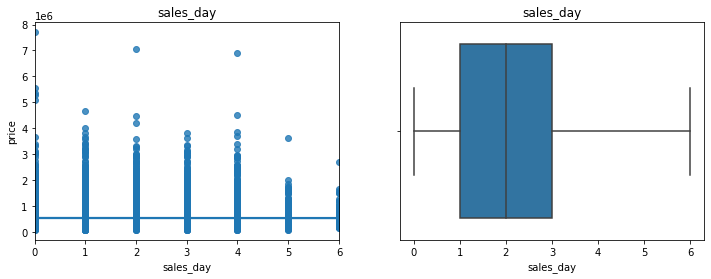

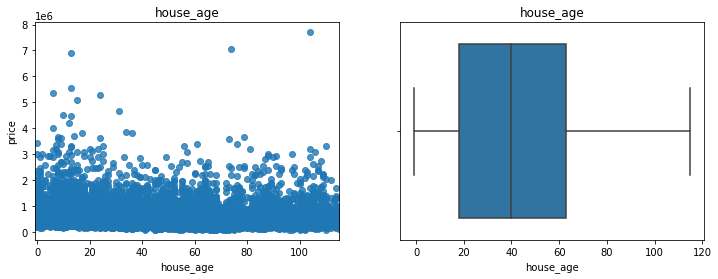

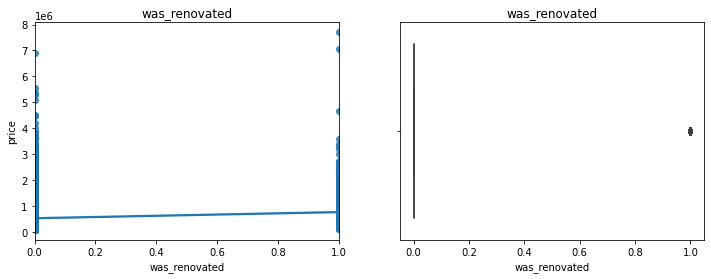

In [31]:
# Let's see scatter and box plots for all columns 

for column in df.columns:
    scatter_box_plots(df, column)

In [32]:
# Checking the value counts on the weird looking box plots

check_unique_cols = ['sqft_lot','waterfront','view', 'was_renovated', 'sqft_lot15']
for col in check_unique_cols:
    print('Column: {}'.format(df[col].value_counts()))

Column: 5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
Column: 0    21451
1      146
Name: waterfront, dtype: int64
Column: 0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64
Column: 0    20853
1      744
Name: was_renovated, dtype: int64
Column: 5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64


>Lots of outlier issues here and these can be addressed on a case to case basis. Before that, we're seeing that waterfront, view & was_renovated don't offer much relevent info and can probably be dropped.

In [33]:
# dropping the irrelevant columns

df.drop(['waterfront', 'view', 'was_renovated'], axis = 1, inplace = True)
df.head()

price  bedrooms  bathrooms  ...  sales_month  sales_day  house_age
0 221900.000         3      1.000  ...           10          0         59
1 538000.000         3      2.250  ...           12          1         63
2 180000.000         2      1.000  ...            2          2         82
3 604000.000         4      3.000  ...           12          1         49
4 510000.000         3      2.000  ...            2          2         28

[5 rows x 18 columns]

### Q1 - Are there any outliers that may affect our model?
>Let's face it...most likely.  Let's see just how bad it is.  

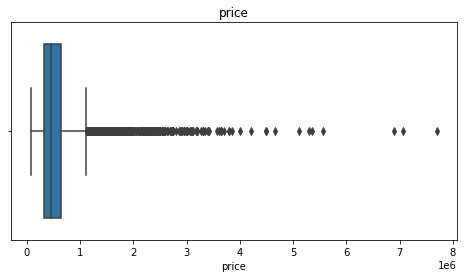

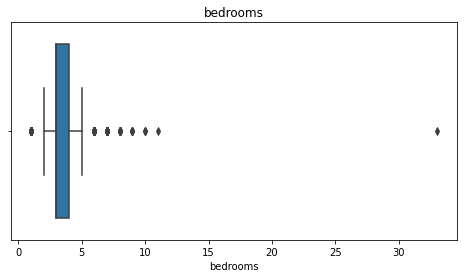

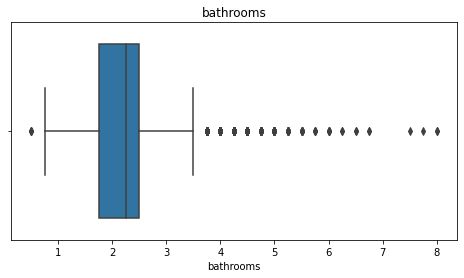

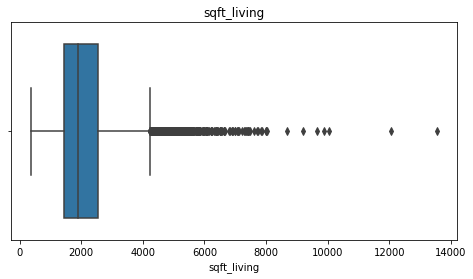

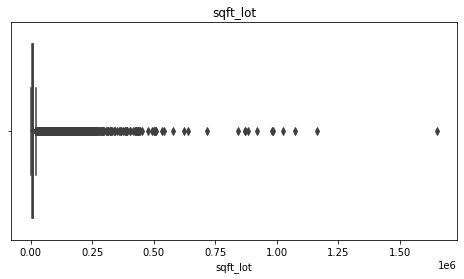

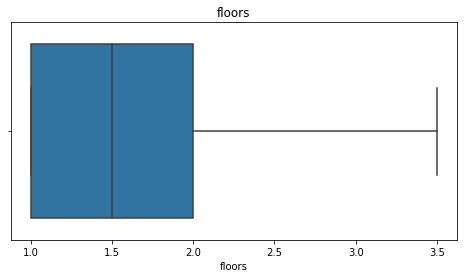

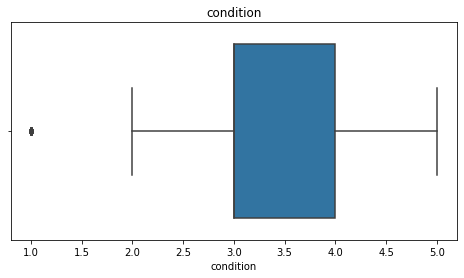

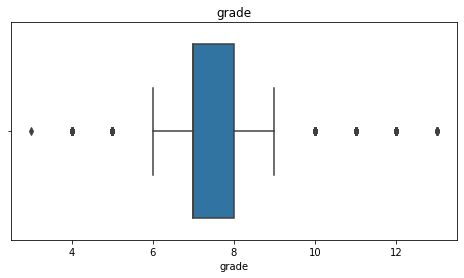

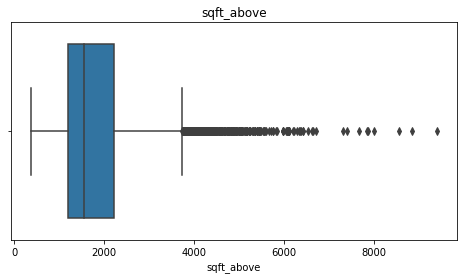

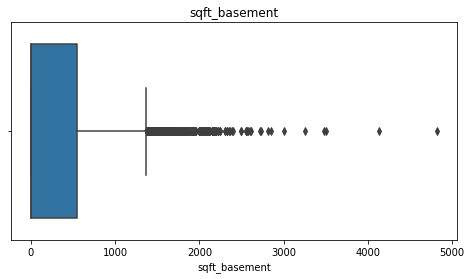

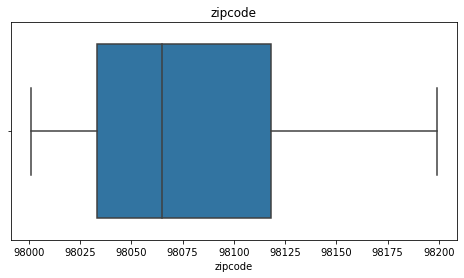

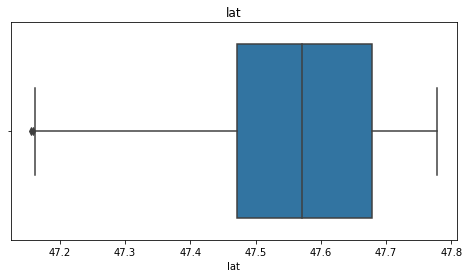

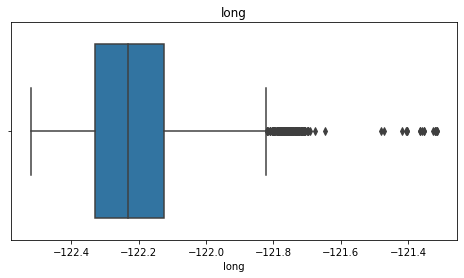

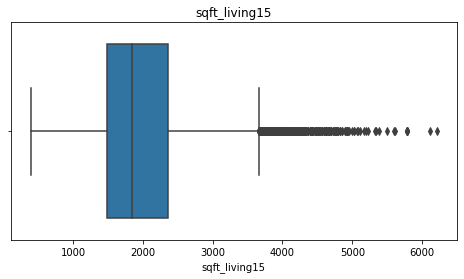

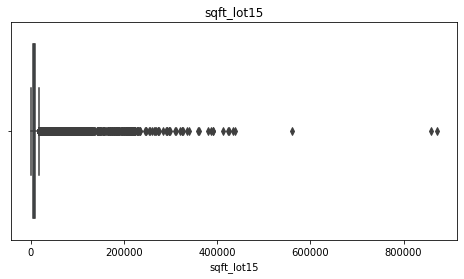

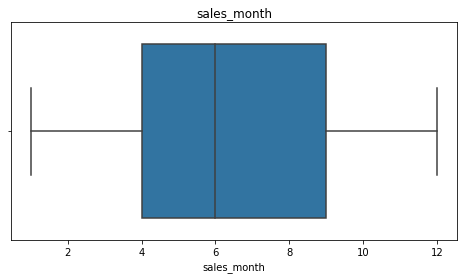

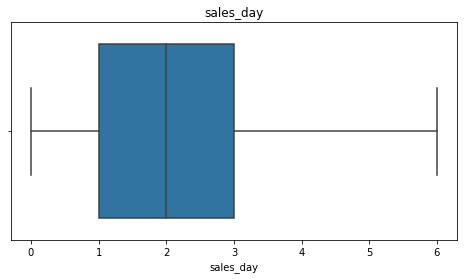

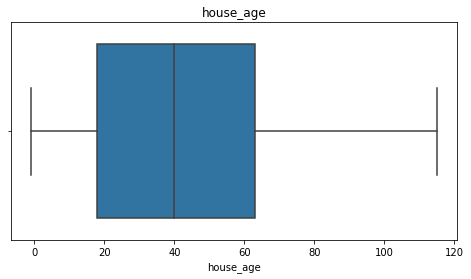

In [34]:
# Let's check out some boxplots as well

for column in df.columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

In [35]:
df.shape

(21597, 18)

In [36]:
# Finding and removing outliers with a series of functions

for column in df.columns:
    df = remove_outliers_iqr(df, column)

df.shape

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(15311, 18)

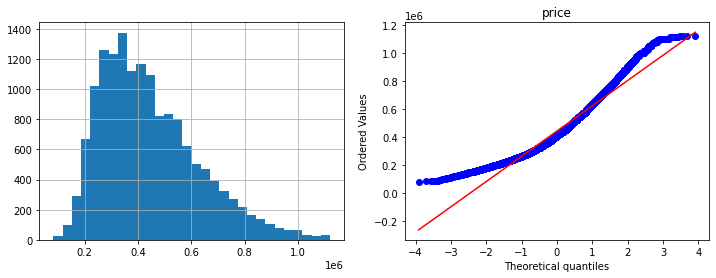

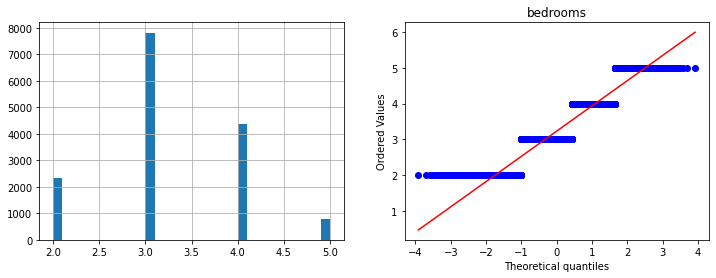

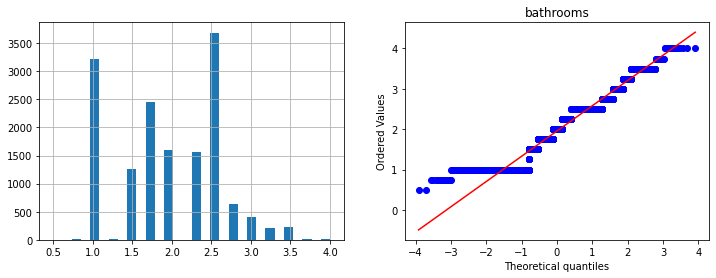

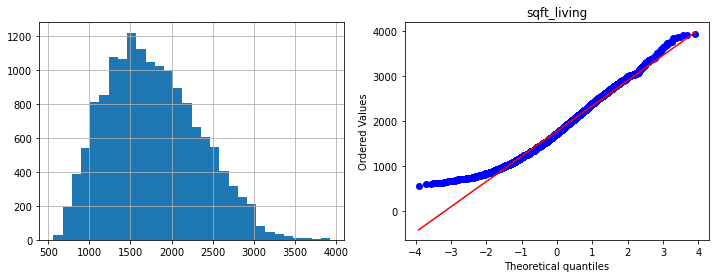

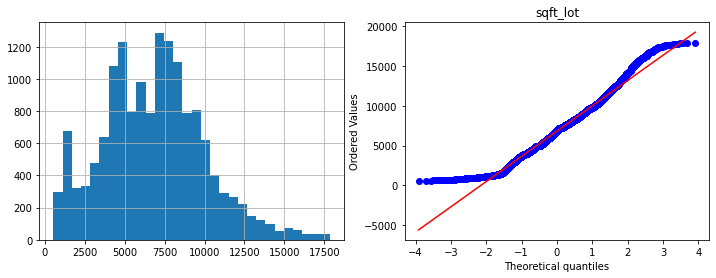

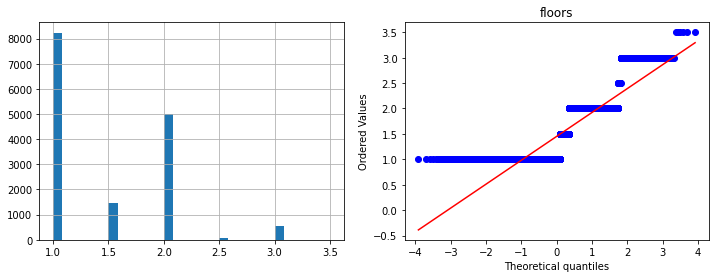

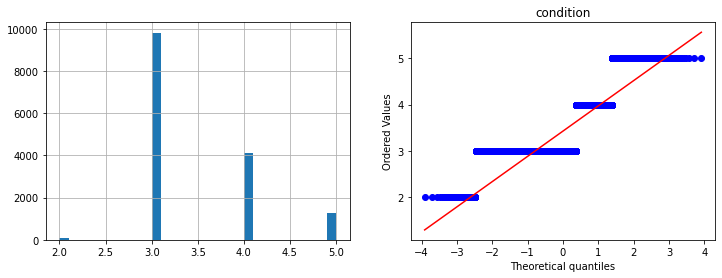

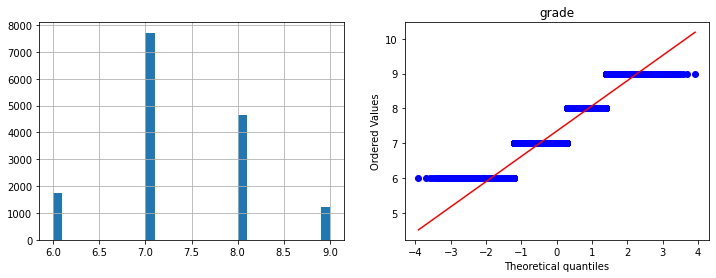

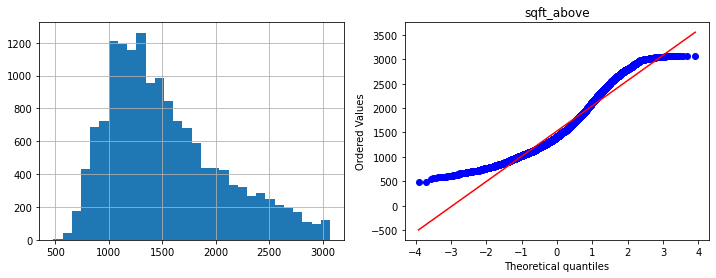

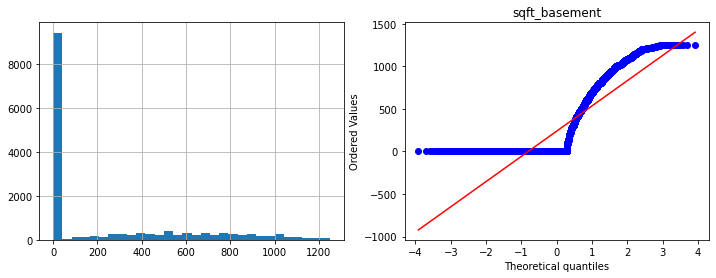

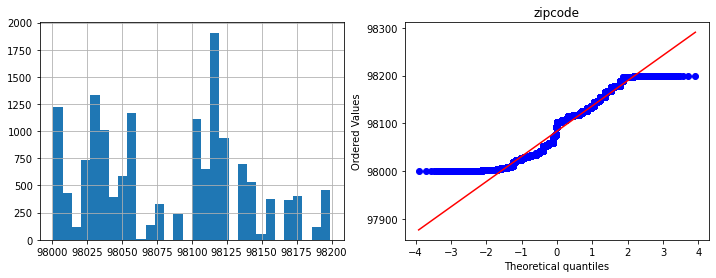

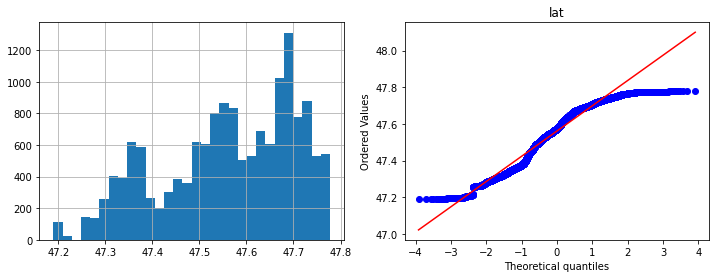

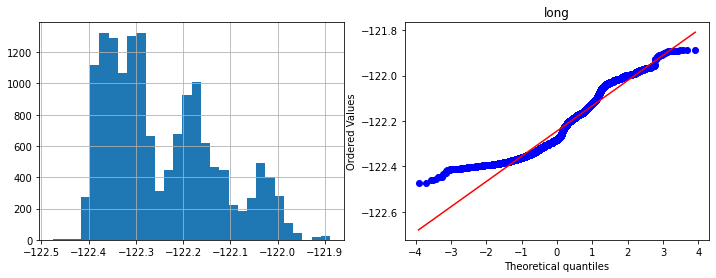

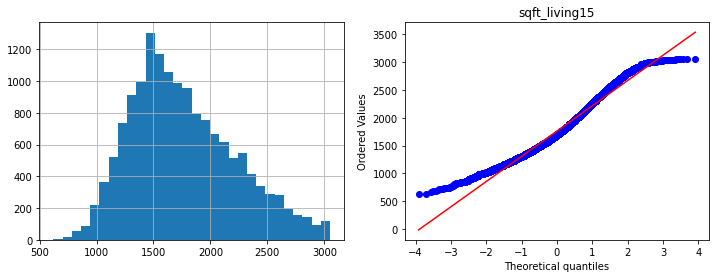

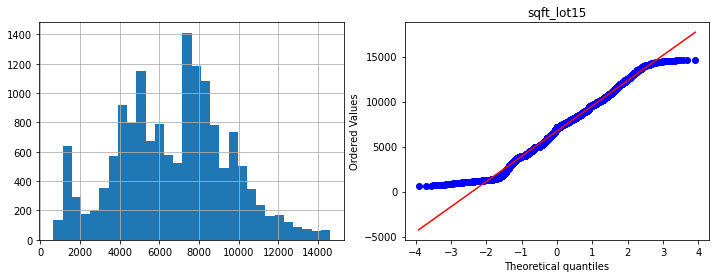

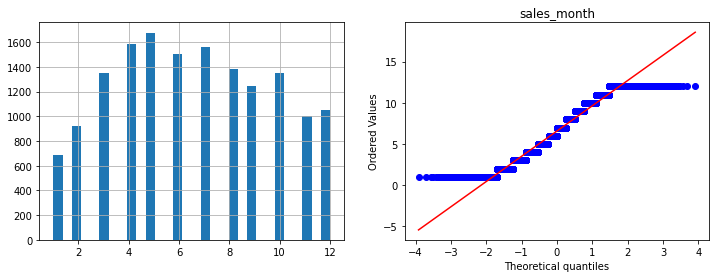

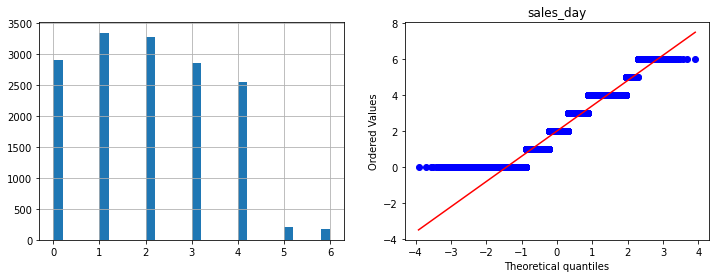

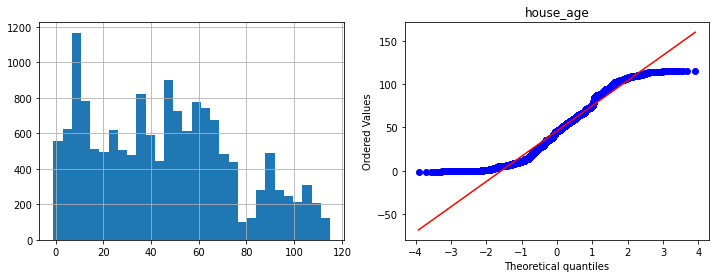

In [37]:
# Checking to see how we did

for column in df.columns:
    diagnostic_plots(df, column)

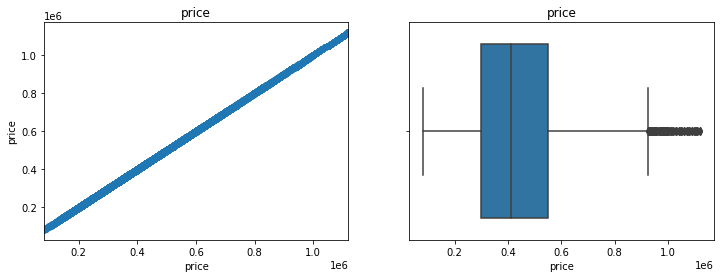

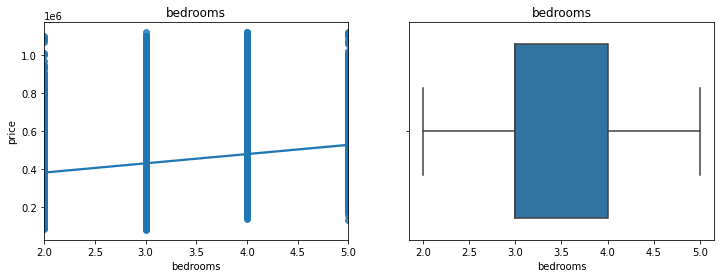

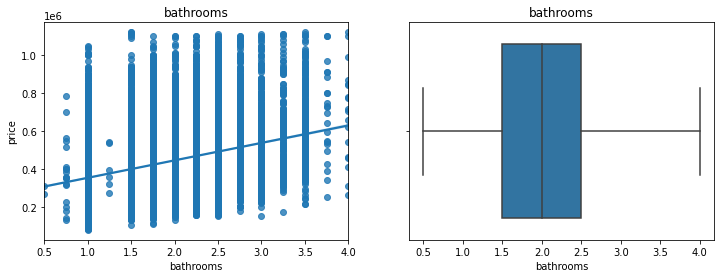

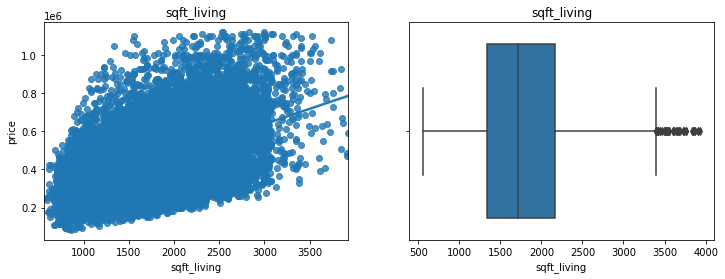

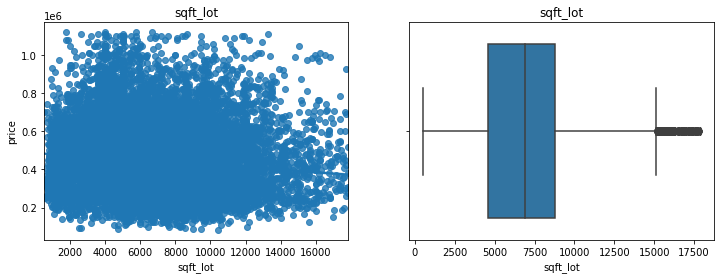

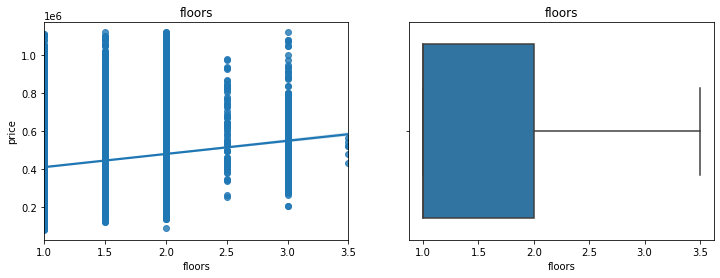

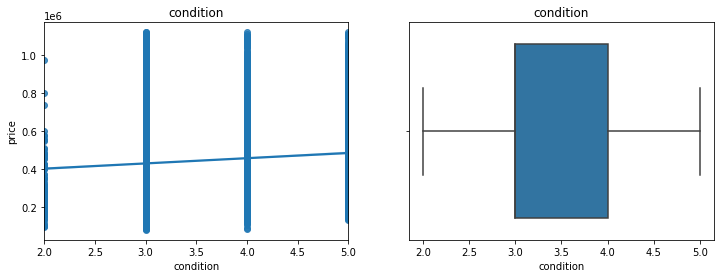

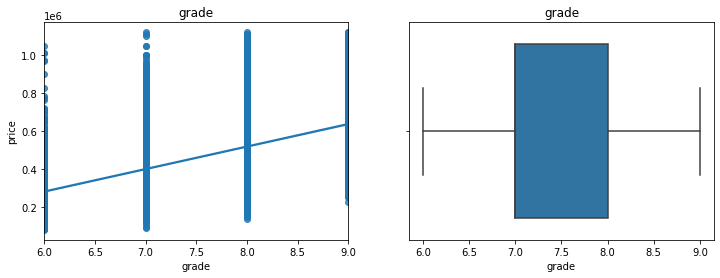

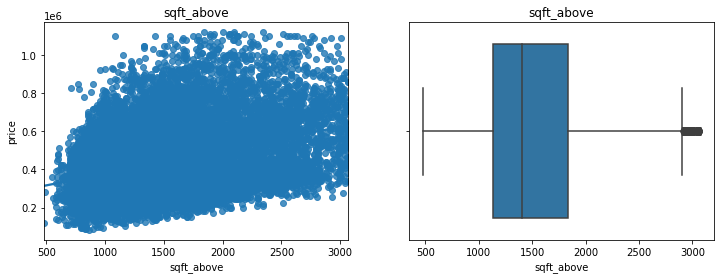

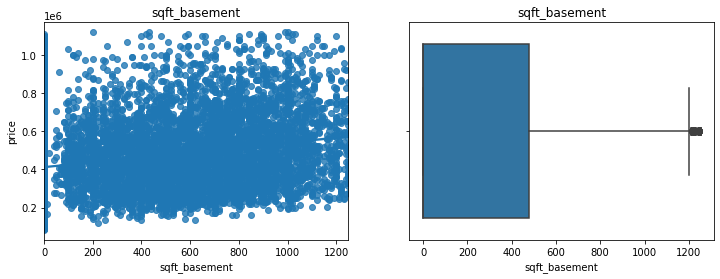

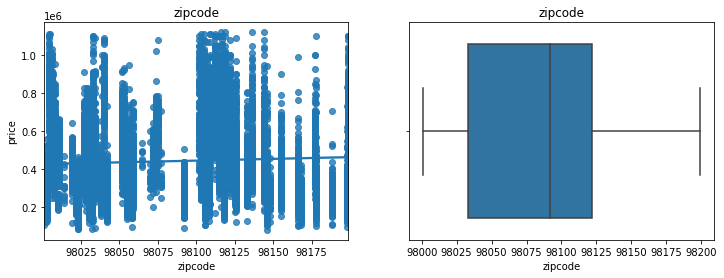

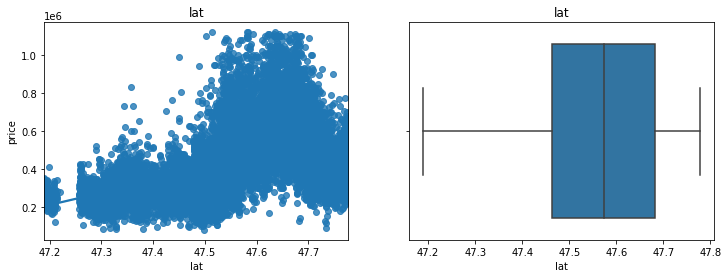

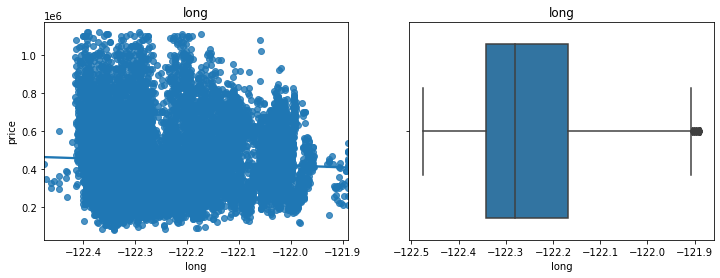

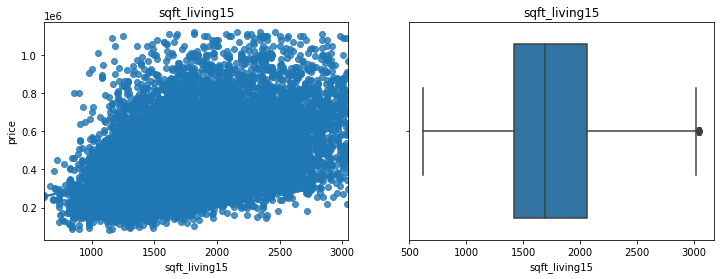

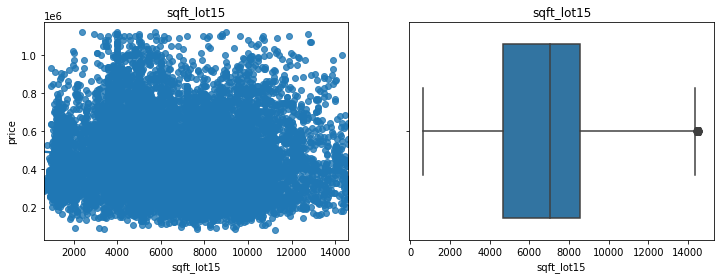

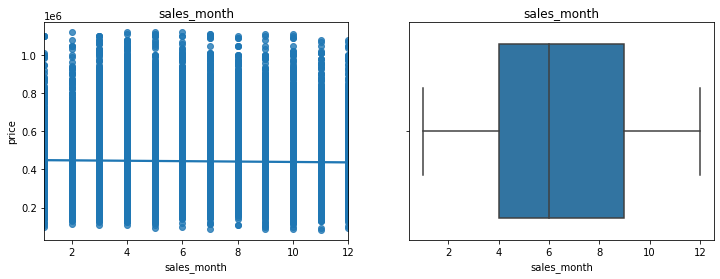

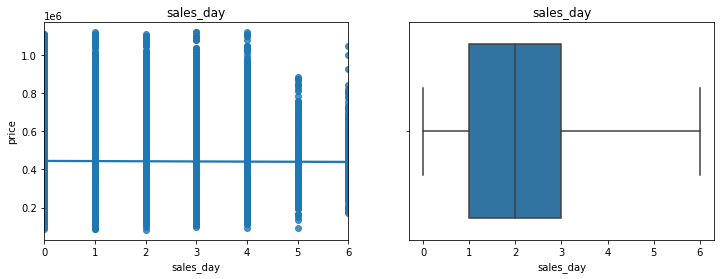

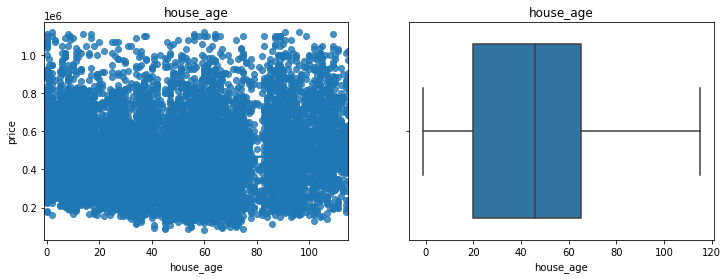

In [38]:
# Checking to see how we did

for column in df.columns:
    scatter_box_plots(df, column)

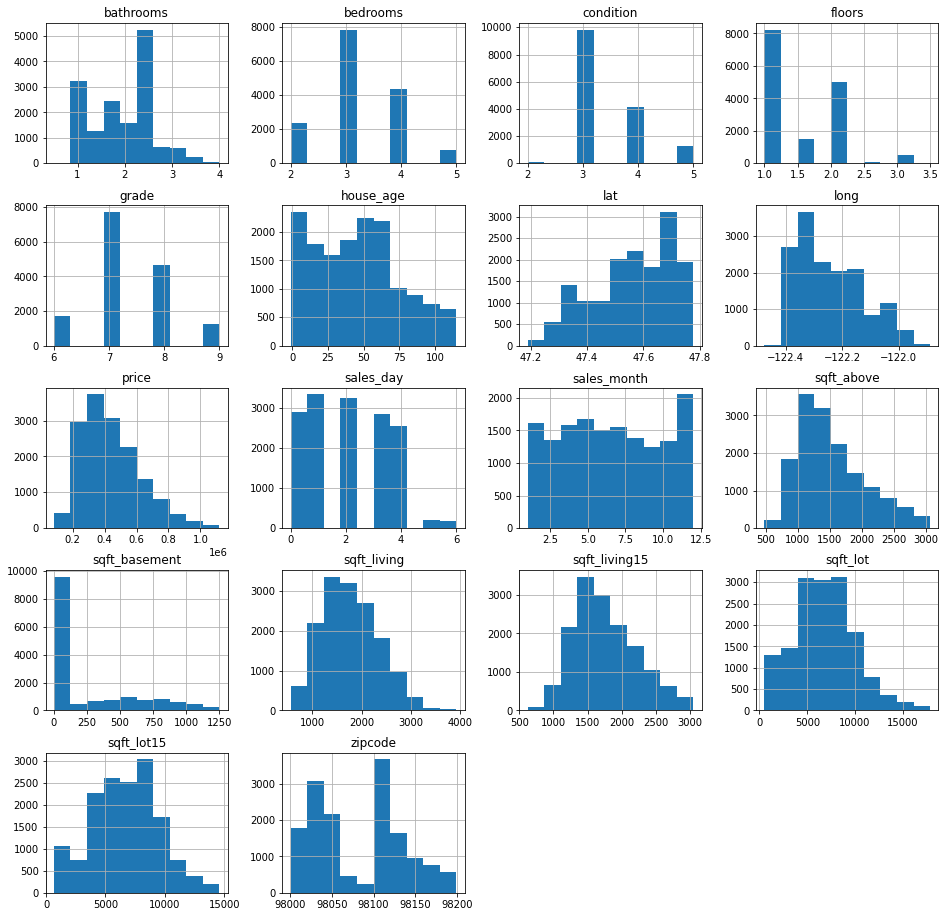

In [39]:
df.hist(figsize = (16, 16));

#### Outlier Removal

In [40]:
# I suspect some of these columns will become categorical
# sqft_basement and house_age still looks especially irregular, so let's see the value counts

print(df['sqft_basement'].value_counts())
print(df['house_age'].value_counts())

0.000      9414
500.000     186
600.000     175
700.000     172
800.000     160
           ... 
243.000       1
248.000       1
784.000       1
207.000       1
602.000       1
Name: sqft_basement, Length: 158, dtype: int64
 9     318
 11    301
 8     291
 7     279
 10    278
      ... 
 82     20
 79     19
 80     11
 81      9
-1       8
Name: house_age, Length: 117, dtype: int64


#### Second Round of Outlier Removal - ??

In [41]:
# Second round of outlier removal using the same method

# for column in df.columns:
#     df = remove_outliers_iqr(df, column)

# df.shape

In [42]:
# for column in df.columns:
#     diagnostic_plots(df, column)

In [43]:
# for column in df.columns:
#     scatter_box_plots(df, column)

#### Results

<b>Are there outliers affecting the normality of the data?</b><br>
Yes, there were extensive issues with outliers in our data. 

### Q2 - Could any of the columns be categorical?

>Thus far, all of the columns represent numerical data.  Let's investigate whether or not any of these could actually be categorical. After checking out the plots above, it seems as though the following columns could actually be categorical: <b> floors, waterfront, view, and was_renovated. </b>

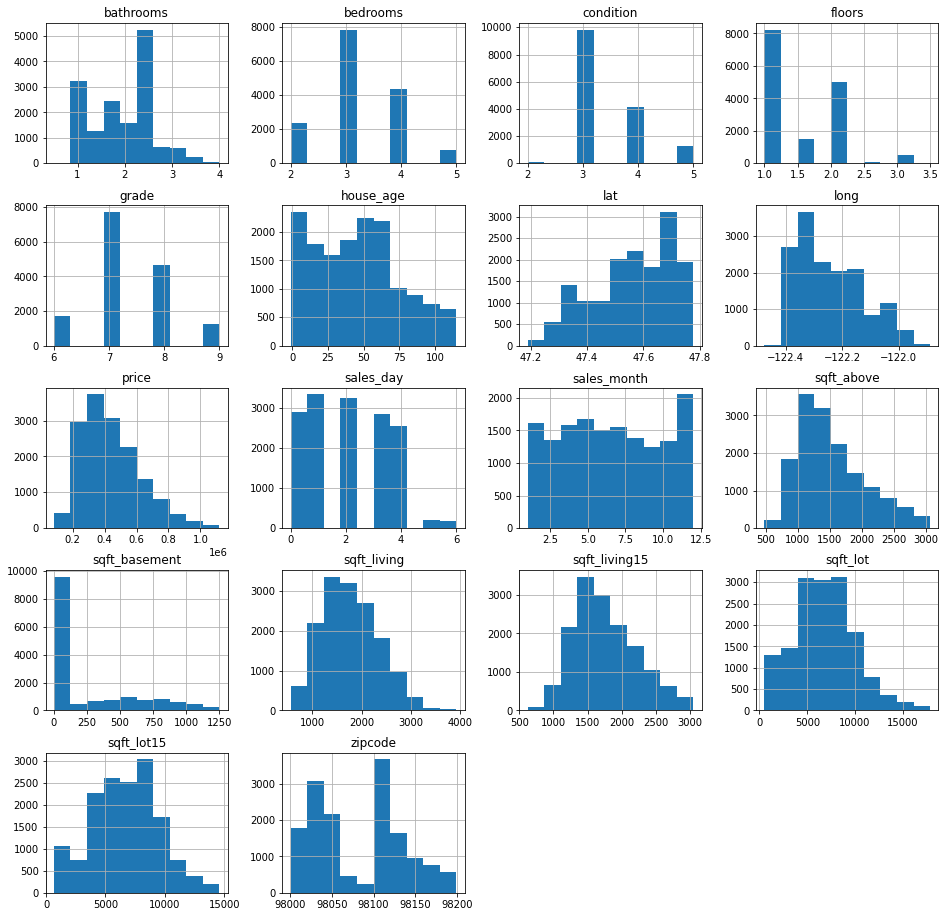

In [44]:
df.hist(figsize = (16,16));

>Checking out the plots above, there are a few columns that could be considered categorical.  Since sqft_basement looks so weird right now, let's see what's going on there first. 

In [45]:
df['sqft_basement'].value_counts()

0.000      9414
500.000     186
600.000     175
700.000     172
800.000     160
           ... 
243.000       1
248.000       1
784.000       1
207.000       1
602.000       1
Name: sqft_basement, Length: 158, dtype: int64

>Since there's a huge amount of 0's in this column, let's change this to a categorical column called "has_basement".

In [46]:
# Change the column to a boolean

for i in df['sqft_basement']:
    if i > 0:
        df['sqft_basement'].replace(i, 1, inplace = True)

# Change column name
df['has_basement'] = df['sqft_basement']
df['has_basement'] = df['has_basement'].astype(int)
df.drop(['sqft_basement'], axis = 1, inplace = True)

print(df['has_basement'].value_counts())
df.head()

0    9414
1    5897
Name: has_basement, dtype: int64


price  bedrooms  bathrooms  ...  sales_day  house_age  has_basement
0 221900.000         3      1.000  ...          0         59             0
1 538000.000         3      2.250  ...          1         63             1
2 180000.000         2      1.000  ...          2         82             0
3 604000.000         4      3.000  ...          1         49             1
4 510000.000         3      2.000  ...          2         28             0

[5 rows x 18 columns]

>Zipcode should definitely be converted into an object as it represents specific locations and not a numerical value.  Other columns that should be converted to objects are <b> has_basement, condition, and grade.</b>

In [47]:
# Changing zipcode, has_basement, condition, and grade to an object

df['zipcode'] = df['zipcode'].astype('object') 
df['has_basement'] = df['has_basement'].astype('object') 
df['condition'] = df['condition'].astype('object') 
df['grade'] = df['grade'].astype('object') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15311 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15311 non-null  float64
 1   bedrooms       15311 non-null  int64  
 2   bathrooms      15311 non-null  float64
 3   sqft_living    15311 non-null  int64  
 4   sqft_lot       15311 non-null  int64  
 5   floors         15311 non-null  float64
 6   condition      15311 non-null  object 
 7   grade          15311 non-null  object 
 8   sqft_above     15311 non-null  int64  
 9   zipcode        15311 non-null  object 
 10  lat            15311 non-null  float64
 11  long           15311 non-null  float64
 12  sqft_living15  15311 non-null  int64  
 13  sqft_lot15     15311 non-null  int64  
 14  sales_month    15311 non-null  int64  
 15  sales_day      15311 non-null  int64  
 16  house_age      15311 non-null  int64  
 17  has_basement   15311 non-null  object 
dtypes: flo

In [48]:
# Separating Categorical and Numerical columns for future use

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

print('Categorical Columns: {}'.format(str(cat_cols)))
print('Numerical Columns: {}'.format(str(num_cols)) )

Categorical Columns: ['condition', 'grade', 'zipcode', 'has_basement']
Numerical Columns: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_month', 'sales_day', 'house_age']


In [49]:
#one-hot encoding for category columns

df_dummies = df.copy()
df_dummies = pd.get_dummies(df, columns = cat_cols, drop_first = True)
print(df_dummies.shape)
df_dummies.head()

(15311, 89)


price  bedrooms  bathrooms  ...  zipcode_98198  zipcode_98199  has_basement_1
0 221900.000         3      1.000  ...              0              0               0
1 538000.000         3      2.250  ...              0              0               1
2 180000.000         2      1.000  ...              0              0               0
3 604000.000         4      3.000  ...              0              0               1
4 510000.000         3      2.000  ...              0              0               0

[5 rows x 89 columns]

#### Results

<b>Could any columns actually be categorical?</b><br>
Yes, several columns turned out to be more categorical in nature. 

### Q3 - Are there any multicolinearity issues?

In [50]:
# super helpful

# heatmap(df_dummies)

>The heatmap wasn't super helpful but the previous model had a warning indicating that there were, indeed, issues with multicolinearity.  We'll have to run feature selection methods to remove this issue.  First, we'll deal with correlated features and then give a Lasso feature selection a shot.  

#### Remove Correlated Features

In [51]:
# Pull out correlated features

corr_features = correlation(df_dummies, 0.8)
print(len(corr_features))
corr_features

2


{'condition_4', 'sqft_lot15'}

In [52]:
# drop the columns with correlation

df_dummies.drop(labels = corr_features, axis = 1, inplace = True)
df_dummies

price  bedrooms  ...  zipcode_98199  has_basement_1
0     221900.000         3  ...              0               0
1     538000.000         3  ...              0               1
2     180000.000         2  ...              0               0
3     604000.000         4  ...              0               1
4     510000.000         3  ...              0               0
...          ...       ...  ...            ...             ...
21592 360000.000         3  ...              0               0
21593 400000.000         4  ...              0               0
21594 402101.000         2  ...              0               0
21595 400000.000         3  ...              0               0
21596 325000.000         2  ...              0               0

[15311 rows x 87 columns]

#### Remove Features using VIF

In [53]:
# Create VIF scores for each column

x = df_dummies.drop('price', axis = 1)
x = sm.add_constant(x)
vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif_results = pd.Series(dict(zip(x.columns, vif)))
vif_results

const            71109162.218
bedrooms                1.743
bathrooms               2.859
sqft_living            11.315
sqft_lot                2.215
                     ...     
zipcode_98178           4.230
zipcode_98188           2.025
zipcode_98198           2.362
zipcode_98199           9.705
has_basement_1          3.916
Length: 87, dtype: float64

In [54]:
#Separate the bad VIF scores

threshold = 6
bad_vif = list(vif_results[vif_results > threshold].index)
if 'const' in bad_vif:
    bad_vif.remove('const')
bad_vif

['sqft_living',
 'sqft_above',
 'lat',
 'long',
 'zipcode_98006',
 'zipcode_98008',
 'zipcode_98011',
 'zipcode_98019',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98056',
 'zipcode_98059',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98119',
 'zipcode_98122',
 'zipcode_98125',
 'zipcode_98126',
 'zipcode_98133',
 'zipcode_98144',
 'zipcode_98155',
 'zipcode_98177',
 'zipcode_98199']

In [55]:
# Best practice is to keep the zipcode columns intact for now so let's remove the others

df_dummies.drop(['sqft_living', 'sqft_above', 'lat', 'long'], axis = 1, inplace = True)
df_dummies

price  bedrooms  ...  zipcode_98199  has_basement_1
0     221900.000         3  ...              0               0
1     538000.000         3  ...              0               1
2     180000.000         2  ...              0               0
3     604000.000         4  ...              0               1
4     510000.000         3  ...              0               0
...          ...       ...  ...            ...             ...
21592 360000.000         3  ...              0               0
21593 400000.000         4  ...              0               0
21594 402101.000         2  ...              0               0
21595 400000.000         3  ...              0               0
21596 325000.000         2  ...              0               0

[15311 rows x 83 columns]

#### Remove Quasi-Constant Features

In [56]:
# Filtering out Quasi-Constant Features using the variance threshold.  0.01 should be equivalent to 99%
# Checking out the amount of keepers

sel = VarianceThreshold(threshold = 0.01)
sel.fit(df_dummies)
sum(sel.get_support())

60

In [57]:
# Checking out the keepers

features_to_keep = df_dummies.columns[sel.get_support()]
features_to_keep

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_living15',
       'sales_month', 'sales_day', 'house_age', 'condition_3', 'condition_5',
       'grade_7', 'grade_8', 'grade_9', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98006', 'zipcode_98008', 'zipcode_98023', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98042',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98074', 'zipcode_98092',
       'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107',
       'zipcode_98108', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117',
       'zipcode_98118', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126',
       'zipcode_98133', 'zipcode_98136', 'zipcode_98144', 'zipcode_98146',
       'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177',
       'zipcode_98

In [58]:
# Remove the non-keepers

df_dummies = sel.transform(df_dummies)

In [59]:
# Return to this to a dataframe

df_dummies = pd.DataFrame(df_dummies)
df_dummies.columns = features_to_keep
print(df_dummies.shape)
df_dummies.head()

(15311, 60)


price  bedrooms  bathrooms  ...  zipcode_98198  zipcode_98199  has_basement_1
0 221900.000     3.000      1.000  ...          0.000          0.000           0.000
1 538000.000     3.000      2.250  ...          0.000          0.000           1.000
2 180000.000     2.000      1.000  ...          0.000          0.000           0.000
3 604000.000     4.000      3.000  ...          0.000          0.000           1.000
4 510000.000     3.000      2.000  ...          0.000          0.000           0.000

[5 rows x 60 columns]

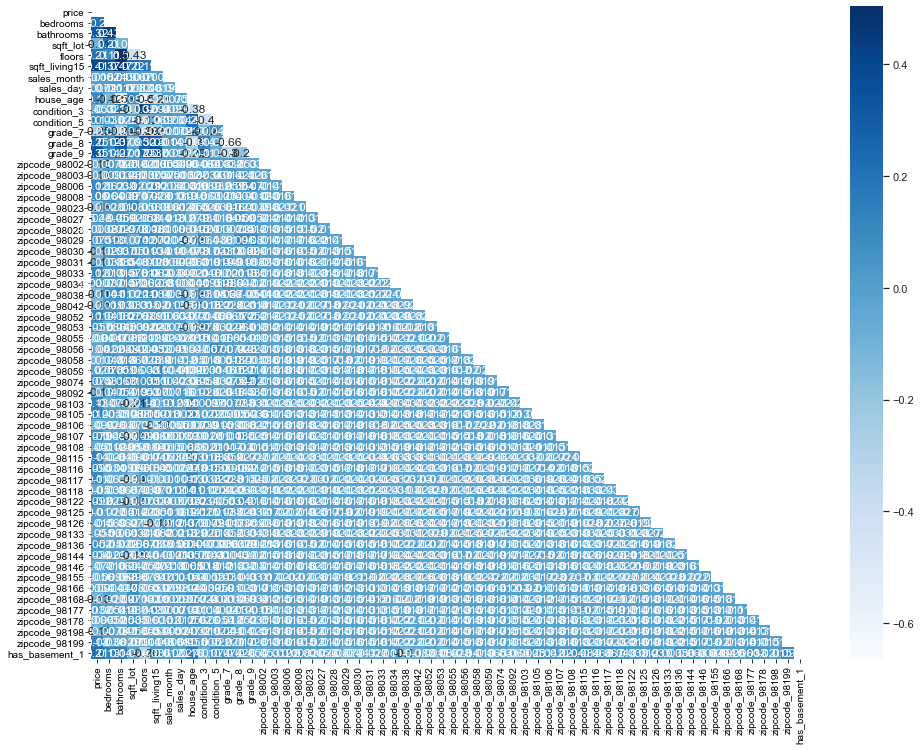

In [60]:
# Let's see an updated heatmap

heatmap(df_dummies)

#### Result 


<b>Are there any multicolinearity issues?</b><br>
Yes, there were extensive multicolinearity issues within our dataset. 

## Model

In [61]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

### Baseline Model
>Let's throw down a baseline model to see where we're at so far.  

In [62]:
# Running a baseline model 

features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     554.7
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:14:21   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15251   BIC:                         3.978e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.013e+04   7863.204      2.560      0.010    4714.428    3.55e+04
bedrooms        1.122e+04   1325.381      8.464      0.000    8620.549    1.38e+04
bathrooms       4.004e+04   2065.121     19.390      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0561      0.366     -2.883      0.004      -1.774      -0.338
floors          2.256e+04   2456.390      9.183      0.000    1.77e+04    2.74e+04
sqft_living15     89.0424      2.543     35.020      0.000      84.059      94.026
sales_month    -2039.2723    270.066     -7.551      0.000   -2568.635   -1509.910
sales_day       -872.1057    578.159     -1.508      0.131   -2005.367     261.156
house_age       1847.0171     44.921     41.117      0.000    1758.967    1935.068
condition_3    -2.005e+04   2123.380     -9.444      0.000   -2.42e+04   -1.59e+04
condition_5     2.349e+04   3407.004      6.895      0.000    1.68e+04    3.02e+04
grade_7         5.682e+04   3102.896     18.312      0.000    5.07e+04    6.29e+04
grade_8         1.347e+05   3855.750     34.944      0.000    1.27e+05    1.42e+05
grade_9         2.524e+05   5097.622     49.519      0.000    2.42e+05    2.62e+05
zipcode_98002  -1.619e+05   8337.187    -19.413      0.000   -1.78e+05   -1.46e+05
zipcode_98003  -1.804e+05   7106.737    -25.386      0.000   -1.94e+05   -1.66e+05
zipcode_98006   4.075e+04   7163.537      5.688      0.000    2.67e+04    5.48e+04
zipcode_98008   3.471e+04   7287.420      4.763      0.000    2.04e+04     4.9e+04
zipcode_98023  -2.043e+05   5720.562    -35.718      0.000   -2.16e+05   -1.93e+05
zipcode_98027   1.704e+04   8144.714      2.092      0.036    1077.085     3.3e+04
zipcode_98028   -6.29e+04   7420.590     -8.477      0.000   -7.74e+04   -4.84e+04
zipcode_98029   1.896e+04   6992.880      2.712      0.007    5256.381    3.27e+04
zipcode_98030  -1.742e+05   7314.204    -23.816      0.000   -1.89e+05    -1.6e+05
zipcode_98031  -1.727e+05   7178.165    -24.059      0.000   -1.87e+05   -1.59e+05
zipcode_98033   1.064e+05   6583.473     16.157      0.000    9.35e+04    1.19e+05
zipcode_98034  -7004.6435   5413.827     -1.294      0.196   -1.76e+04    3607.104
zipcode_98038   -1.32e+05   5590.884    -23.610      0.000   -1.43e+05   -1.21e+05
zipcode_98042  -1.583e+05   5799.671    -27.296      0.000    -1.7e+05   -1.47e+05
zipcode_98052    4.27e+04   5742.084      7.437      0.000    3.14e+04     5.4e+04
zipcode_98053   1.143e+05   8071.278     14.157      0.000    9.84e+04     1.3e+05
zipcode_98055  -1.559e+05   7444.554    -20.943      0.000   -1.71e+05   -1.41e+05
zipcode_98056  -8.287e+04   6466.518    -12.816      0.000   -9.55e+04   -7.02e+04
zipcode_98058  -1.537e+05   6059.290    -25.362      0.000   -1.66e+05   -1.42e+05
zipcode_98059  -8.622e+04   6562.762    -13.138      0.000   -9.91e+04   -7.34e+04
zipcode_9807

#### Dropping Insignificant Coefficients


> We want to drop columns that show an insignifcant p-value.  Therefore, the following columns have to go: <b>, sales_day, zipcode_98034, zipcode_98074, zipcode_98144, zipcode_98177.

In [63]:
np.set_printoptions(suppress=True)

In [64]:
df_dummies.drop(['sales_day', 'zipcode_98034', 'zipcode_98074', 'zipcode_98144', 'zipcode_98177'], 
                axis = 1, inplace = True)

### Secondary Model

In [65]:
# Let's see how that worked

features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     605.8
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:14:22   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15256   BIC:                         3.977e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.623e+04   7603.789      2.135      0.033    1330.320    3.11e+04
bedrooms        1.115e+04   1324.743      8.418      0.000    8554.673    1.37e+04
bathrooms       4.002e+04   2064.060     19.388      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0422      0.358     -2.908      0.004      -1.745      -0.340
floors          2.289e+04   2444.961      9.363      0.000    1.81e+04    2.77e+04
sqft_living15     89.1077      2.539     35.094      0.000      84.131      94.085
sales_month    -2023.1685    269.857     -7.497      0.000   -2552.121   -1494.216
house_age       1848.4206     44.391     41.640      0.000    1761.409    1935.432
condition_3    -2.003e+04   2122.649     -9.436      0.000   -2.42e+04   -1.59e+04
condition_5     2.352e+04   3406.653      6.905      0.000    1.68e+04    3.02e+04
grade_7         5.671e+04   3102.228     18.281      0.000    5.06e+04    6.28e+04
grade_8         1.347e+05   3852.353     34.959      0.000    1.27e+05    1.42e+05
grade_9         2.527e+05   5087.930     49.660      0.000    2.43e+05    2.63e+05
zipcode_98002  -1.603e+05   8226.929    -19.486      0.000   -1.76e+05   -1.44e+05
zipcode_98003  -1.787e+05   6976.088    -25.619      0.000   -1.92e+05   -1.65e+05
zipcode_98006   4.232e+04   7039.082      6.012      0.000    2.85e+04    5.61e+04
zipcode_98008   3.662e+04   7160.276      5.114      0.000    2.26e+04    5.07e+04
zipcode_98023  -2.027e+05   5556.090    -36.480      0.000   -2.14e+05   -1.92e+05
zipcode_98027   1.845e+04   8027.878      2.298      0.022    2709.974    3.42e+04
zipcode_98028  -6.138e+04   7298.438     -8.410      0.000   -7.57e+04   -4.71e+04
zipcode_98029   2.028e+04   6860.978      2.956      0.003    6830.254    3.37e+04
zipcode_98030  -1.726e+05   7189.010    -24.003      0.000   -1.87e+05   -1.58e+05
zipcode_98031  -1.711e+05   7050.217    -24.268      0.000   -1.85e+05   -1.57e+05
zipcode_98033    1.08e+05   6447.508     16.752      0.000    9.54e+04    1.21e+05
zipcode_98038  -1.306e+05   5426.733    -24.060      0.000   -1.41e+05    -1.2e+05
zipcode_98042  -1.567e+05   5640.909    -27.771      0.000   -1.68e+05   -1.46e+05
zipcode_98052   4.424e+04   5582.596      7.924      0.000    3.33e+04    5.52e+04
zipcode_98053   1.159e+05   7953.435     14.570      0.000       1e+05    1.31e+05
zipcode_98055  -1.542e+05   7320.701    -21.063      0.000   -1.69e+05    -1.4e+05
zipcode_98056  -8.142e+04   6325.144    -12.872      0.000   -9.38e+04    -6.9e+04
zipcode_98058  -1.519e+05   5907.180    -25.721      0.000   -1.64e+05    -1.4e+05
zipcode_98059  -8.455e+04   6426.546    -13.157      0.000   -9.72e+04    -7.2e+04
zipcode_98092  -2.039e+05   7118.716    -28.640      0.000   -2.18e+05    -1.9e+05
zipcode_98103   7.724e+04   5132.615     15.048      0.000    6.72e+04    8.73e+04
zipcode_9810

In [66]:
# Checking the mean of residuals

model.resid.mean()

-1.3747515844088845e-07

<Figure size 864x432 with 0 Axes>

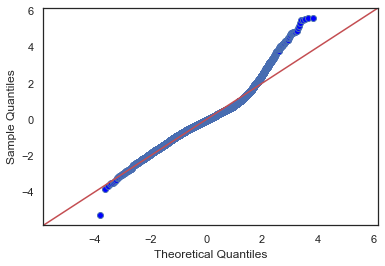

In [67]:
# qqplot to check for linearity 

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

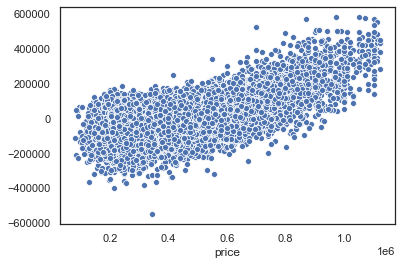

In [68]:
# Scatter plot to check homoscedasticity 

sns.scatterplot(df_dummies['price'], model.resid, );

### Model Validation with Statsmodels

In [69]:
# Separate into train and test sets

# df_train, df_test = train_test_split(df_dummies, test_size = 0.3, random_state = 30)

# print(len(df_train), len(df_test))

In [70]:
# Separate into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], 
                                                    test_size = 0.3, random_state = 30)

print(len(X_train), len(X_test), len(y_train), len(y_test))

10717 4594 10717 4594


#### Run Train Set

In [71]:
# Run a training model

features = '+'.join(df_dummies.drop('price', axis=1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     605.8
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:14:23   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15256   BIC:                         3.977e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.623e+04   7603.789      2.135      0.033    1330.320    3.11e+04
bedrooms        1.115e+04   1324.743      8.418      0.000    8554.673    1.37e+04
bathrooms       4.002e+04   2064.060     19.388      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0422      0.358     -2.908      0.004      -1.745      -0.340
floors          2.289e+04   2444.961      9.363      0.000    1.81e+04    2.77e+04
sqft_living15     89.1077      2.539     35.094      0.000      84.131      94.085
sales_month    -2023.1685    269.857     -7.497      0.000   -2552.121   -1494.216
house_age       1848.4206     44.391     41.640      0.000    1761.409    1935.432
condition_3    -2.003e+04   2122.649     -9.436      0.000   -2.42e+04   -1.59e+04
condition_5     2.352e+04   3406.653      6.905      0.000    1.68e+04    3.02e+04
grade_7         5.671e+04   3102.228     18.281      0.000    5.06e+04    6.28e+04
grade_8         1.347e+05   3852.353     34.959      0.000    1.27e+05    1.42e+05
grade_9         2.527e+05   5087.930     49.660      0.000    2.43e+05    2.63e+05
zipcode_98002  -1.603e+05   8226.929    -19.486      0.000   -1.76e+05   -1.44e+05
zipcode_98003  -1.787e+05   6976.088    -25.619      0.000   -1.92e+05   -1.65e+05
zipcode_98006   4.232e+04   7039.082      6.012      0.000    2.85e+04    5.61e+04
zipcode_98008   3.662e+04   7160.276      5.114      0.000    2.26e+04    5.07e+04
zipcode_98023  -2.027e+05   5556.090    -36.480      0.000   -2.14e+05   -1.92e+05
zipcode_98027   1.845e+04   8027.878      2.298      0.022    2709.974    3.42e+04
zipcode_98028  -6.138e+04   7298.438     -8.410      0.000   -7.57e+04   -4.71e+04
zipcode_98029   2.028e+04   6860.978      2.956      0.003    6830.254    3.37e+04
zipcode_98030  -1.726e+05   7189.010    -24.003      0.000   -1.87e+05   -1.58e+05
zipcode_98031  -1.711e+05   7050.217    -24.268      0.000   -1.85e+05   -1.57e+05
zipcode_98033    1.08e+05   6447.508     16.752      0.000    9.54e+04    1.21e+05
zipcode_98038  -1.306e+05   5426.733    -24.060      0.000   -1.41e+05    -1.2e+05
zipcode_98042  -1.567e+05   5640.909    -27.771      0.000   -1.68e+05   -1.46e+05
zipcode_98052   4.424e+04   5582.596      7.924      0.000    3.33e+04    5.52e+04
zipcode_98053   1.159e+05   7953.435     14.570      0.000       1e+05    1.31e+05
zipcode_98055  -1.542e+05   7320.701    -21.063      0.000   -1.69e+05    -1.4e+05
zipcode_98056  -8.142e+04   6325.144    -12.872      0.000   -9.38e+04    -6.9e+04
zipcode_98058  -1.519e+05   5907.180    -25.721      0.000   -1.64e+05    -1.4e+05
zipcode_98059  -8.455e+04   6426.546    -13.157      0.000   -9.72e+04    -7.2e+04
zipcode_98092  -2.039e+05   7118.716    -28.640      0.000   -2.18e+05    -1.9e+05
zipcode_98103   7.724e+04   5132.615     15.048      0.000    6.72e+04    8.73e+04
zipcode_9810

<Figure size 864x432 with 0 Axes>

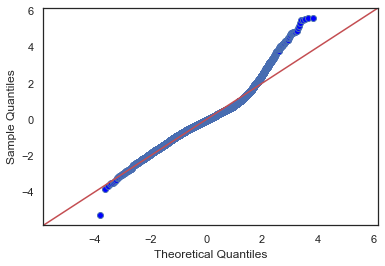

In [72]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

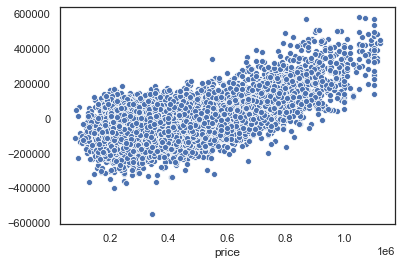

In [73]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_train['price'], model.resid);

#### Run Test Set

In [74]:
# Run a model on the test set

features = '+'.join(X_test.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, X_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     194.9
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:14:24   Log-Likelihood:                -59500.
No. Observations:                4594   AIC:                         1.191e+05
Df Residuals:                    4539   BIC:                         1.195e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        308.8782   1.35e+04      0.023      0.982   -2.61e+04    2.67e+04
bedrooms        9579.0586   2390.937      4.006      0.000    4891.659    1.43e+04
bathrooms       3.968e+04   3689.383     10.755      0.000    3.24e+04    4.69e+04
sqft_lot          -0.5989      0.631     -0.950      0.342      -1.835       0.637
floors          3.302e+04   4264.851      7.743      0.000    2.47e+04    4.14e+04
sqft_living15     88.9707      4.547     19.567      0.000      80.057      97.885
sales_month    -1608.1670    488.402     -3.293      0.001   -2565.673    -650.661
house_age       1952.7038     78.572     24.852      0.000    1798.664    2106.744
condition_3    -1.831e+04   3810.400     -4.805      0.000   -2.58e+04   -1.08e+04
condition_5     2.669e+04   6039.906      4.419      0.000    1.49e+04    3.85e+04
grade_7         4.833e+04   5609.420      8.617      0.000    3.73e+04    5.93e+04
grade_8         1.254e+05   6961.866     18.015      0.000    1.12e+05    1.39e+05
grade_9         2.545e+05   9184.665     27.704      0.000    2.36e+05    2.72e+05
zipcode_98002   -1.68e+05   1.64e+04    -10.241      0.000      -2e+05   -1.36e+05
zipcode_98003  -1.764e+05   1.17e+04    -15.055      0.000   -1.99e+05   -1.53e+05
zipcode_98006   5.024e+04   1.27e+04      3.944      0.000    2.53e+04    7.52e+04
zipcode_98008   3.061e+04    1.3e+04      2.359      0.018    5168.449     5.6e+04
zipcode_98023  -1.945e+05   1.04e+04    -18.647      0.000   -2.15e+05   -1.74e+05
zipcode_98027   1.311e+04   1.51e+04      0.867      0.386   -1.65e+04    4.27e+04
zipcode_98028  -6.947e+04   1.29e+04     -5.390      0.000   -9.47e+04   -4.42e+04
zipcode_98029   1.968e+04   1.34e+04      1.463      0.143   -6684.048     4.6e+04
zipcode_98030  -1.776e+05   1.18e+04    -15.050      0.000   -2.01e+05   -1.54e+05
zipcode_98031  -1.653e+05   1.25e+04    -13.215      0.000    -1.9e+05   -1.41e+05
zipcode_98033   1.284e+05   1.08e+04     11.842      0.000    1.07e+05     1.5e+05
zipcode_98038   -1.26e+05      1e+04    -12.551      0.000   -1.46e+05   -1.06e+05
zipcode_98042   -1.46e+05      1e+04    -14.543      0.000   -1.66e+05   -1.26e+05
zipcode_98052   3.957e+04   1.04e+04      3.804      0.000    1.92e+04       6e+04
zipcode_98053   1.221e+05   1.42e+04      8.595      0.000    9.43e+04     1.5e+05
zipcode_98055   -1.35e+05   1.34e+04    -10.098      0.000   -1.61e+05   -1.09e+05
zipcode_98056  -8.052e+04   1.09e+04     -7.413      0.000   -1.02e+05   -5.92e+04
zipcode_98058  -1.503e+05   1.05e+04    -14.373      0.000   -1.71e+05    -1.3e+05
zipcode_98059  -7.916e+04   1.09e+04     -7.240      0.000   -1.01e+05   -5.77e+04
zipcode_98092  -2.133e+05   1.36e+04    -15.705      0.000    -2.4e+05   -1.87e+05
zipcode_98103   7.431e+04   9395.490      7.909      0.000    5.59e+04    9.27e+04
zipcode_9810

<Figure size 864x432 with 0 Axes>

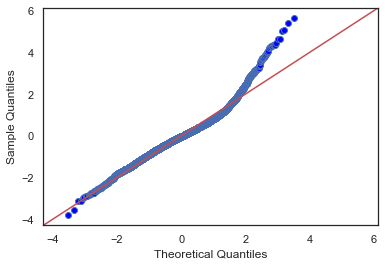

In [75]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

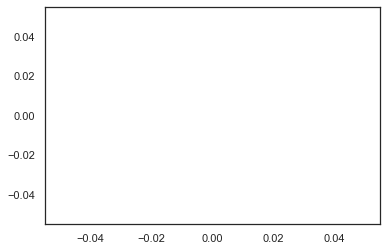

In [76]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_train['price'], model.resid);

#### Model Validation

In [77]:
# Couldn't figure out a good way to do this so I searched for method of using sklearn with statsmodels
# Pulled this class from 

from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors 
    Source: https://sukhbinder.wordpress.com/2018/08/07/cross-validation-score-with-statsmodels/"""
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [78]:
# Assigning X and y 

X = df_dummies.drop(['price'], axis = 1)
y = df_dummies['price']

In [79]:
# Calculating the Cross Validation Score

print(cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2'))
print(cross_val_score(LinearRegression(),X, y, scoring='r2'))

[0.68153841 0.67322689 0.68575018 0.69991633 0.65012206]
[0.68153841 0.67322689 0.68575018 0.69991633 0.65012206]


In [80]:
# Printing the mean of Cross Validation Scores

cv_ols = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2')

print('Cross Validation Score: {}'.format(cv_ols.mean()))

Cross Validation Score: 0.678110773564583


### Model Validation with Scikit-Learn  - Doesn't work yet, but don't want to delete it

In [81]:
# Separate into train and test sets

# X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop, df_dummies['price'], 
#                                                     test_size = 0.3, random_state = 30)

# print(len(X_train), len(X_test), len(y_train), len(y_test))

In [82]:
# Run scikit-learn Linear Regression Model

# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import classification_report

# # Fit the model to train data
# linreg = LinearRegression()
# linreg.fit(X_train, y_train)
# LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
# Get predictions 

# y_hat_train = linreg.predict(X_train)
# y_hat_test = linreg.predict(X_test)

In [84]:
# Train & Test Residuals

# train_residuals = y_hat_train - y_train
# test_residuals = y_hat_test - y_test

In [85]:
# X = df_dummies.drop('price', axis = 1)
# y = df_dummies['price']

In [86]:
# # Find the Mean Squared Error

# from sklearn.metrics import mean_squared_error

# train_mse = mean_squared_error(y_train, y_hat_train)
# test_mse = mean_squared_error(y_test, y_hat_test)

# print('Train Mean Squarred Error:', train_mse)
# print('Test Mean Squarred Error:', test_mse)

In [87]:
# Get Cross Validation Score

# from sklearn.metrics import mean_squared_error, make_scorer
# from sklearn.model_selection import cross_val_score

# mse = make_scorer(mean_squared_error)

# cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
# cv_5_results

In [88]:
#Get the mean of the Cross Validation Scores

# print('Cross Validation Score: {}'.format(cv_5_results.mean()))

In [89]:
# import random
# random.seed(110)

# train_err = []
# test_err = []
# t_sizes = list(range(5,100,5))
# for t_size in t_sizes:
#     X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], test_size=t_size/100)
#     linreg.fit(X_train, y_train)
#     y_hat_train = linreg.predict(X_train)
#     y_hat_test = linreg.predict(X_test)
#     train_err.append(mean_squared_error(y_train, y_hat_train))
#     test_err.append(mean_squared_error(y_test, y_hat_test))
# plt.scatter(t_sizes, train_err, label='Training Error')
# plt.scatter(t_sizes, test_err, label='Testing Error')
# plt.legend();

In [90]:
# random.seed(900)

# train_err = []
# test_err = []
# t_sizes = range(5,100,5)
# for t_size in t_sizes:
#     temp_train_err = []
#     temp_test_err = []
#     for i in range(10):
#         X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], test_size=t_size/100)
#         linreg.fit(X_train, y_train)
#         y_hat_train = linreg.predict(X_train)
#         y_hat_test = linreg.predict(X_test)
#         temp_train_err.append(mean_squared_error(y_train, y_hat_train))
#         temp_test_err.append(mean_squared_error(y_test, y_hat_test))
#     train_err.append(np.mean(temp_train_err))
#     test_err.append(np.mean(temp_test_err))
# plt.scatter(t_sizes, train_err, label='Training Error')
# plt.scatter(t_sizes, test_err, label='Testing Error')
# plt.legend();

#### Code Graveyard (REMOVE BEFORE SUBMITTING)

In [91]:
# Perhaps log transform? 

# log_names = [f'{column}_log' for column in df_dummies.columns]
# df_dummies_log = np.log(df_dummies)
# df_dummies_log.columns = log_names
# df_dummies_log.head()

## Interpret

In [92]:
features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     605.8
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:14:26   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15256   BIC:                         3.977e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.623e+04   7603.789      2.135      0.033    1330.320    3.11e+04
bedrooms        1.115e+04   1324.743      8.418      0.000    8554.673    1.37e+04
bathrooms       4.002e+04   2064.060     19.388      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0422      0.358     -2.908      0.004      -1.745      -0.340
floors          2.289e+04   2444.961      9.363      0.000    1.81e+04    2.77e+04
sqft_living15     89.1077      2.539     35.094      0.000      84.131      94.085
sales_month    -2023.1685    269.857     -7.497      0.000   -2552.121   -1494.216
house_age       1848.4206     44.391     41.640      0.000    1761.409    1935.432
condition_3    -2.003e+04   2122.649     -9.436      0.000   -2.42e+04   -1.59e+04
condition_5     2.352e+04   3406.653      6.905      0.000    1.68e+04    3.02e+04
grade_7         5.671e+04   3102.228     18.281      0.000    5.06e+04    6.28e+04
grade_8         1.347e+05   3852.353     34.959      0.000    1.27e+05    1.42e+05
grade_9         2.527e+05   5087.930     49.660      0.000    2.43e+05    2.63e+05
zipcode_98002  -1.603e+05   8226.929    -19.486      0.000   -1.76e+05   -1.44e+05
zipcode_98003  -1.787e+05   6976.088    -25.619      0.000   -1.92e+05   -1.65e+05
zipcode_98006   4.232e+04   7039.082      6.012      0.000    2.85e+04    5.61e+04
zipcode_98008   3.662e+04   7160.276      5.114      0.000    2.26e+04    5.07e+04
zipcode_98023  -2.027e+05   5556.090    -36.480      0.000   -2.14e+05   -1.92e+05
zipcode_98027   1.845e+04   8027.878      2.298      0.022    2709.974    3.42e+04
zipcode_98028  -6.138e+04   7298.438     -8.410      0.000   -7.57e+04   -4.71e+04
zipcode_98029   2.028e+04   6860.978      2.956      0.003    6830.254    3.37e+04
zipcode_98030  -1.726e+05   7189.010    -24.003      0.000   -1.87e+05   -1.58e+05
zipcode_98031  -1.711e+05   7050.217    -24.268      0.000   -1.85e+05   -1.57e+05
zipcode_98033    1.08e+05   6447.508     16.752      0.000    9.54e+04    1.21e+05
zipcode_98038  -1.306e+05   5426.733    -24.060      0.000   -1.41e+05    -1.2e+05
zipcode_98042  -1.567e+05   5640.909    -27.771      0.000   -1.68e+05   -1.46e+05
zipcode_98052   4.424e+04   5582.596      7.924      0.000    3.33e+04    5.52e+04
zipcode_98053   1.159e+05   7953.435     14.570      0.000       1e+05    1.31e+05
zipcode_98055  -1.542e+05   7320.701    -21.063      0.000   -1.69e+05    -1.4e+05
zipcode_98056  -8.142e+04   6325.144    -12.872      0.000   -9.38e+04    -6.9e+04
zipcode_98058  -1.519e+05   5907.180    -25.721      0.000   -1.64e+05    -1.4e+05
zipcode_98059  -8.455e+04   6426.546    -13.157      0.000   -9.72e+04    -7.2e+04
zipcode_98092  -2.039e+05   7118.716    -28.640      0.000   -2.18e+05    -1.9e+05
zipcode_98103   7.724e+04   5132.615     15.048      0.000    6.72e+04    8.73e+04
zipcode_9810

In [93]:
model.params

Intercept          16234.656
bedrooms           11151.328
bathrooms          40018.488
sqft_lot              -1.042
floors             22893.046
sqft_living15         89.108
sales_month        -2023.169
house_age           1848.421
condition_3       -20028.723
condition_5        23521.840
grade_7            56713.228
grade_8           134674.780
grade_9           252668.217
zipcode_98002    -160309.321
zipcode_98003    -178722.665
zipcode_98006      42319.424
zipcode_98008      36616.507
zipcode_98023    -202687.621
zipcode_98027      18445.573
zipcode_98028     -61383.274
zipcode_98029      20278.590
zipcode_98030    -172556.976
zipcode_98031    -171096.731
zipcode_98033     108009.956
zipcode_98038    -130564.659
zipcode_98042    -156654.330
zipcode_98052      44235.144
zipcode_98053     115880.440
zipcode_98055    -154198.044
zipcode_98056     -81418.065
zipcode_98058    -151937.022
zipcode_98059     -84553.234
zipcode_98092    -203880.472
zipcode_98103      77237.791
zipcode_98105 

In [94]:
# Convert the coefficient series to a sorted dataframe

coeffs_df = model.params.to_frame()
coeffs_df.columns = ['coeff']
coeffs_df = coeffs_df.sort_values('coeff', ascending = False)
coeffs_df.style.background_gradient(cmap = 'Blues').set_caption('Coefficients')

### Location

> As we can see in the dataframe of coefficients above, location has a very large effect on the overall sale price of a house in King County.  Let's investigate this. 

#### King County Map
Below is a map of King County that shows the average sale price for houses by zipcode.  The more red areas indicate zipcodes with a higher average sale price.  

In [95]:
%%html
<div class='tableauPlaceholder' id='viz1599432982795' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;Mod-2Project&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Mod-2Project&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;Mod-2Project&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1599432982795');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [96]:
coeffs_df = coeffs_df.transpose()
coeffs_df

grade_9    grade_8  ...  zipcode_98023  zipcode_98092
coeff 252668.217 134674.780  ...    -202687.621    -203880.472

[1 rows x 55 columns]

In [97]:
# Get a dataframe of just zipcodes and make it nice

zip_columns = []
for column in coeffs_df.columns:
    if column.startswith('z'):
        zip_columns.append(column)


zipcode_df = coeffs_df[zip_columns]
zipcode_df = zipcode_df.transpose()
zipcode_df = zipcode_df.reset_index()
zipcode_df['zipcode'] = zipcode_df['index']
zipcode_df.drop('index', axis = 1, inplace = True)

# Edit the zipcode column...but not working for some reason
for i in zipcode_df['zipcode']:
    i.replace('zipcode_', '')
    
zipcode_df

coeff        zipcode
0   115880.440  zipcode_98053
1   110853.337  zipcode_98199
2   108777.686  zipcode_98105
3   108009.956  zipcode_98033
4    84510.760  zipcode_98115
5    80058.704  zipcode_98117
6    77237.791  zipcode_98103
7    71344.846  zipcode_98107
8    63566.538  zipcode_98116
9    46849.278  zipcode_98122
10   44235.144  zipcode_98052
11   42319.424  zipcode_98006
12   37080.181  zipcode_98136
13   36616.507  zipcode_98008
14   20278.590  zipcode_98029
15   18445.573  zipcode_98027
16  -11640.959  zipcode_98125
17  -12480.540  zipcode_98126
18  -48417.047  zipcode_98133
19  -54976.096  zipcode_98155
20  -57338.447  zipcode_98118
21  -61383.274  zipcode_98028
22  -78607.736  zipcode_98146
23  -81418.065  zipcode_98056
24  -84514.927  zipcode_98106
25  -84553.234  zipcode_98059
26  -93599.067  zipcode_98166
27  -98932.833  zipcode_98108
28 -127675.281  zipcode_98178
29 -130564.659  zipcode_98038
30 -141826.403  zipcode_98168
31 -147779.853  zipcode_98198
32 -151937.022  zipcode_98058
33 -154198.044  zipcode_98055
34 -156654.330  zipcode_98042
35 -160309.321  zipcode_98002
36 -171096.731  zipcode_98031
37 -172556.976  zipcode_98030
38 -178722.665  zipcode_98003
39 -202687.621  zipcode_98023
40 -203880.472  zipcode_98092

In [98]:
# Let's remove the negatives from the dataframe

# negative_zips = []
# for i in zipcode_df['coeff']:
#     if i < 0:
#         negative_zips.append(i)

# zipcode_df = zipcode_df[~zipcode_df.coeff.isin(negative_zips)]
# zipcode_df

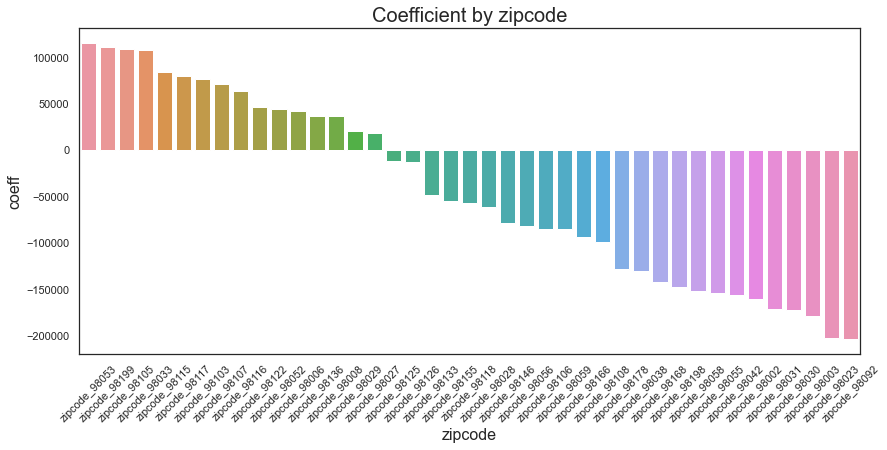

In [99]:
# Create a barplot showing the effect of different zipcodes on the coefficient

coefficient_barplot(zipcode_df, 'zipcode','coeff')

Maybe try to add another Tabeleau map of just these zipcodes

### Grade
Another factor that heavily affects the coefficient is the grade given by the King County Housing Authority.  Here is a breakdown of what the different grades represent.  

> From the King County website.  For more information, <a href="https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r">click here.</a><br><br>
<b>Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:</b>
- 1-3 - Falls short of minimum building standards. Normally cabin or inferior structure.
- 4 - Generally older, low quality construction. Does not meet code.
- 5 - Low construction costs and workmanship. Small, simple design.
- 6 - Lowest grade currently meeting building code. Low quality materials and simple designs.
- 7 - Average grade of construction and design. Commonly seen in plats and older sub-divisions.
- 8 - Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
- 9 - Better architectural design with extra interior and exterior design and quality.
- 10 - Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
- 11 - Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
- 12 - Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
- 13 - Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [100]:
# Get a dataframe of just grades and make it nice

grade_columns = []
for column in coeffs_df.columns:
    if column.startswith('g'):
        grade_columns.append(column)


grade_df = coeffs_df[grade_columns]
grade_df = grade_df.transpose()
grade_df = grade_df.reset_index()
grade_df['grade'] = grade_df['index']
grade_df.drop('index', axis = 1, inplace = True)

for i in grade_df['grade']:
    i.replace('grade_', '')

grade_df

coeff    grade
0 252668.217  grade_9
1 134674.780  grade_8
2  56713.228  grade_7

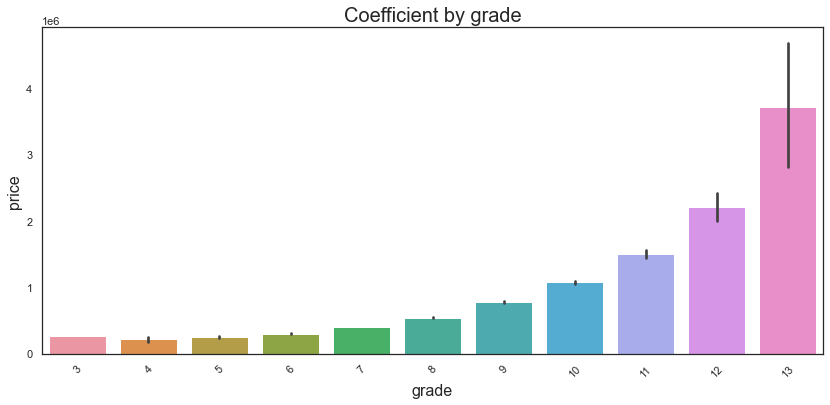

In [101]:
# Create a barplot showing the effect of grade on the coefficient

coefficient_barplot(plotting_df, 'grade','price')

### Condition
Another factor that heavily affects the coefficient is the condition rating given by the King County Housing Authority.  Here is a breakdown of what the different grades represent.  

> From the King County website.  For more information, <a href="https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r">click here.</a><br><br>
<b>Relative to age and grade. Coded 1-5.</b><br>
1 = Poor <br> Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.<br><br>
2 = Fair<br> Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.<br><br>
3 = Average<br> Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.<br><br>
4 = Good<br>  No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.<br><br>
5 = Very Good <br>
All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

In [102]:
condition_columns = []
for column in coeffs_df.columns:
    if column.startswith('condition'):
        condition_columns.append(column)


condition_df = coeffs_df[condition_columns]
condition_df = condition_df.transpose()
condition_df = condition_df.reset_index()
condition_df['condition'] = condition_df['index']
condition_df.drop('index', axis = 1, inplace = True)

condition_df.style.background_gradient(cmap = 'Blues').set_caption('Condition')

#### Condition Plot

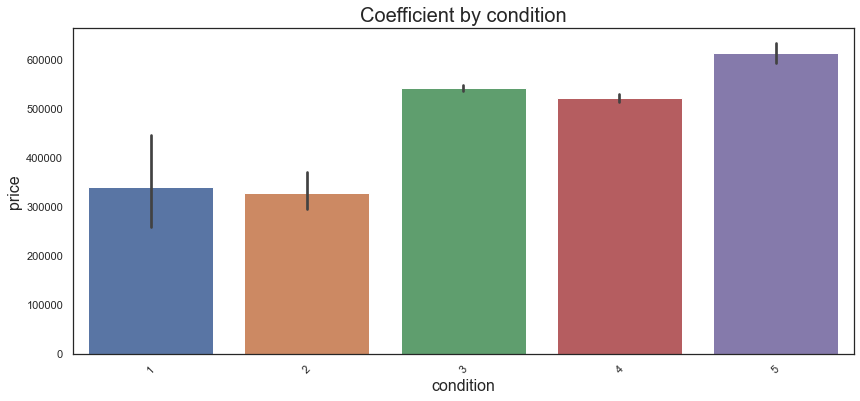

In [103]:
# plotting the condition

coefficient_barplot(plotting_df, 'condition', 'price')

>We can see here that homeowners should strive for the top condition rating as a condition rating of 5 increases your sale price b $23,521.  

### Bathrooms

In [104]:
# Separate bathroom coefficient from the main coeff_df.

bathroom_columns = []
for column in coeffs_df.columns:
    if column.startswith('bath'):
        bathroom_columns.append(column)


bathroom_df = coeffs_df[bathroom_columns]
bathroom_df = bathroom_df.transpose()
bathroom_df = bathroom_df.reset_index()
bathroom_df['bathrooms'] = bathroom_df['index']
bathroom_df.drop('index', axis = 1, inplace = True)

bathroom_df

coeff  bathrooms
0 40018.488  bathrooms

>The above dataframe shows that with each additional bathroom, the sale price of a house in King County increases by $40,018.

##### Bathrooms Plot

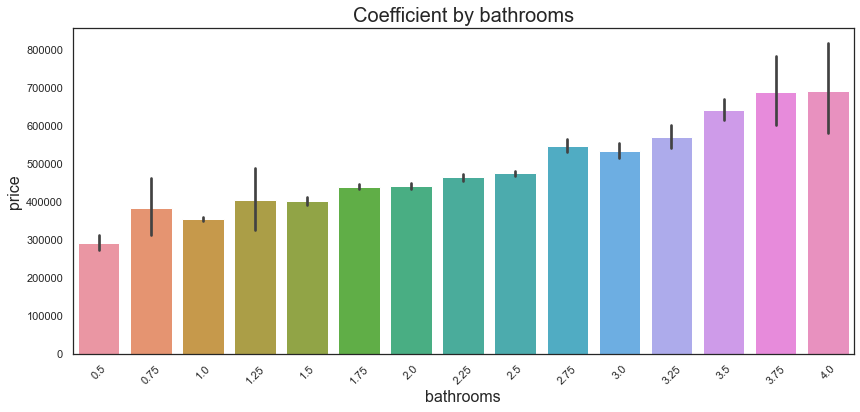

In [105]:
coefficient_barplot(df, 'bathrooms', 'price')

### Basement

In [106]:
# Separate basement coefficient from the main coeff_df.

basement_columns = []
for column in coeffs_df.columns:
    if column.startswith('has'):
        basement_columns.append(column)


basement_df = coeffs_df[basement_columns]
basement_df = basement_df.transpose()
basement_df = basement_df.reset_index()
basement_df['basement'] = basement_df['index']
basement_df.drop('index', axis = 1, inplace = True)

basement_df

coeff        basement
0 25934.894  has_basement_1

>The above dataframe shows that if the house has a basement in King County, the sale price increases by $40,018.

#### Basement Plot

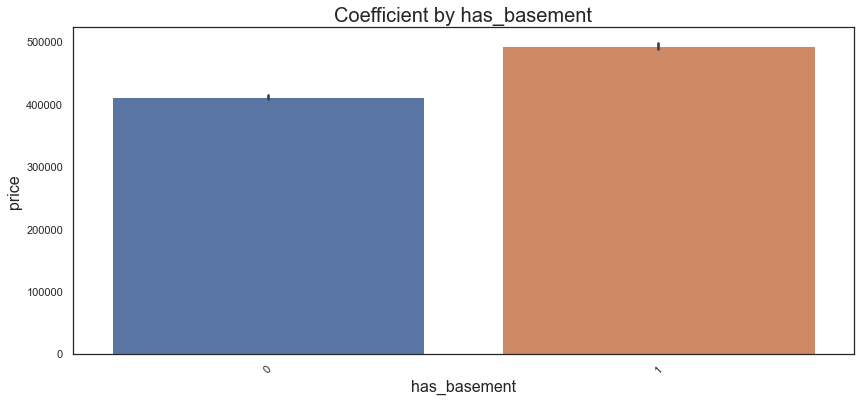

In [107]:
# creating a plot for basement feature

coefficient_barplot(df, 'has_basement', 'price')

### Top Features

In [108]:
# Create a dataframe of the top features and their coefficients...and make it look nice

top_features = {'zipcode': zipcode_df['coeff'].mean(), 'grade': grade_df['coeff'].mean(),
                'condition': condition_df['coeff'][0], 'bathrooms' : bathroom_df['coeff'],
                'basement': basement_df['coeff']}

top_features_df = pd.DataFrame(top_features)
top_features_df = top_features_df.transpose()
top_features_df.columns = ['coeff']
top_features_df = top_features_df.sort_values('coeff', ascending = False)
top_features_df = top_features_df.reset_index()
top_features_df['feature'] = top_features_df['index']
top_features_df.drop('index', axis = 1, inplace = True)

top_features_df

coeff    feature
0 148018.742      grade
1  40018.488  bathrooms
2  25934.894   basement
3  23521.840  condition
4 -43943.582    zipcode

#### Top Features Plot

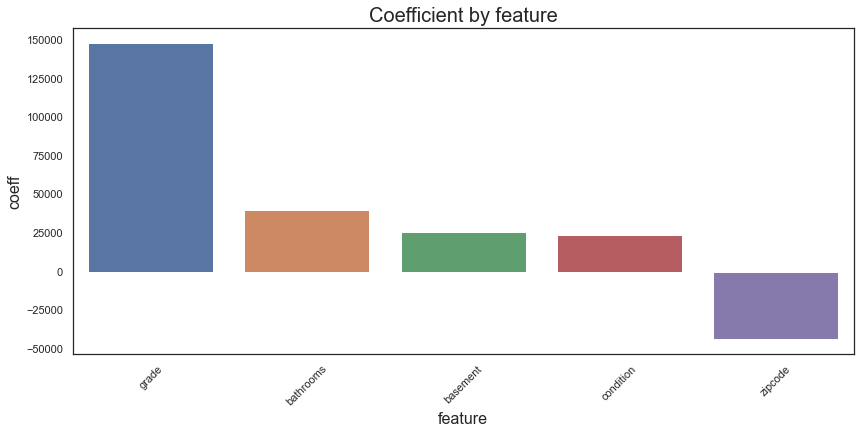

In [109]:
# Create a barplot for the top features

coefficient_barplot(top_features_df, 'feature','coeff')

## Conclusion

### Summary
We have now examined the house sale data for King County, Washington in an attempt to determine what potential sellers can do to increase the finale sale price of their home.  While there are many factors to consider when it comes to home value, we were able to use data scrubbing and linear regression models to accurately it down to a few key features that drive the sale price.  

During this process, we were able to answer several questions:
  - Is the dataset affected by the presence of outliers?
  - Are there issues of data being encoded as the wrong type?
  - Will our initial model be affected by multicolinearity? 
  - Most importantly, what features are most important in driving the overall sale price of a house in King County?
  
We have found that the features that are most important in driving the sale price are <b>Grade, Zipcode, Bathrooms, Basement, and Condition. </b>
    
  - <b> Grade: </b> The grade given by the King County Housing Authority is the largest contributor to overall sale price.  The best return on investment in terms of grade occurs within a grade range of 7-9, with the highest sale prices graded as a 9.  A grade within 7-9 will increase the sale price, on average, by 148,018.74 <br><br>
  - <b> Zipcode: </b> While we can't ask sellers to physically move their homes, we've discovered that houses located within certain zipcodes sell for substantially more than others.  Location is definitely something to consider. If your house is located in one of the top zipcodes, you can expect an average increase of 66,629.05<br><br>
  - <b> Bathrooms: </b> We found that number of bathrooms is a feature that can increase the sale price of a house considerably.  Each bathroom present within the house is worth 40,018.49 toward the sale price. <br><br>
  - <b> Basement: </b> The presence of a basement in the house is another feature that added considerable value.  If a house in King County has a basement, the sale price is expected to increase by 25,934.89 <br><br>
  - <b> Condition: </b> The overall condition of the house also tends to affect the sale price.  If a house has a perfect 5 condition grade, it will add 23,521.84 to the sale price.  
  
<b><center>We are now able to offer potential sellers the following recommenations. </center></b>

### Recommendations
Based on the results of this analysis, we have the following recommendations:

 - Aim for having a <b>Grade</b> of 9.  According to the King County Housing Authority, this would require having "Better architectural design with extra interior and exterior design and quality." <br><br>
 - If possible, increase the amount of <b>Bathrooms</b> in your house. <br><br>
 - If possible, consider creating a <b>Basement</b> or equivalent.<br><br>
 - Make sure your house is able to achieve a 5 in <b>Condition</b> grade.  According to the King County Housing Authority, this would require "All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility."


### Future Work
With more time, we can do better work and also look at several other factors that could potentially drive the sale price much higher.  These include: 

<b><u> Timing: </b></u> <br>  Is there a trend in your neighborhood?  If the market is on the rise in your zipcode, it may be worth waiting til the optimal moment to put the house on the market.

<b><u> Investment Properties: </b></u> <br>  Are there houses in King County that could see a huge return on investment with minor renovations?

<b><u> Creating a Pipeline:</b></u> <br>
Creating a pipeline will make this notebook much easier to read as well as make it more readily available to be used again with new data. 

<center><i><b> Thank you. </b></i></center>